# Lung Adenocarcinoma Patch Classification with the WSSS4LUAD dataset

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox seaborn | tail -n 1
ON_GPU=False
print('Installation is done.')
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True 
!pip install seaborn
!pip install Pillow==9.0.0
!pip install validators matplotlib

Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Installation is done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |████████████████████████████████| 831.4 MB 6.5 kB/s 
     |████████████████████████████████| 22.1 MB 7.2 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.9.1+cu102 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torch>=1.11.0, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torchvision>=0.12.0, but you have torchvision 0.10.1+cu102 which is incompatib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=2cf9a003db2c47ab8586148a98a72921a8fd0e4749e2f5ab2f33cf3fc31a3d12
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


## Imports and Downloads

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tables
import cv2
from PIL import Image
from random import randint 
import torchvision
import tables as pt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import numpy as np
from tiatoolbox.tools import patchextraction
import time
import os
import copy
from sklearn.metrics import cohen_kappa_score,precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import pickle


In [ ]:
import PIL 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(0)



## Directories, and Simple Data Cleaning

In [ ]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 
training_directory = '/content/drive/MyDrive/1.training/1.training/'
validation_directory = '/content/drive/MyDrive/2.validation/2.validation/'
testing_directory = '/content/drive/MyDrive/3.testing/3.testing/'


In [ ]:
plt.style.use('seaborn')

In [ ]:
example_image = Image.open(training_directory+'TCGA-99-7458-01A-01-BS1-13653-4938-[1, 1, 0].png')


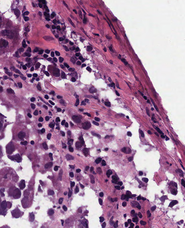

In [ ]:
example_image

In [ ]:
#Match the ground truth to the training image
X_image_strings = list()
training_y = list()

for image_string in os.listdir(training_directory):
  X_image_strings.append(os.path.join(training_directory,image_string))
  new_string = image_string[-13:-4].strip()
  new_label= [int(new_string[-8]),int(new_string[-5]),int(new_string[-2])]
  training_y.append(new_label)

### Sweet spot for shape

In [ ]:
training_shapes = list()
for image in os.listdir(training_directory):
  
  io=cv2.cvtColor(cv2.imread(training_directory+image),cv2.COLOR_BGR2RGB)
  interp_method=PIL.Image.BICUBIC
  io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
  training_shapes.append(np.array(io.shape))
  

In [ ]:
training_shapes = np.array(training_shapes)

(array([ 965.,  998., 1038., 1049.,  991., 1002.,  993.,  982.,  997.,
        1076.]),
 array([150., 165., 180., 195., 210., 225., 240., 255., 270., 285., 300.]),
 <BarContainer object of 10 artists>)

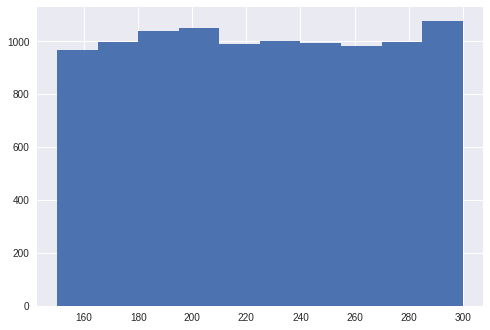

In [ ]:
plt.hist(training_shapes[:,0])

(array([1118., 1003.,  993., 1002., 1080.,  995.,  942.,  997.,  961.,
        1000.]),
 array([150., 165., 180., 195., 210., 225., 240., 255., 270., 285., 300.]),
 <BarContainer object of 10 artists>)

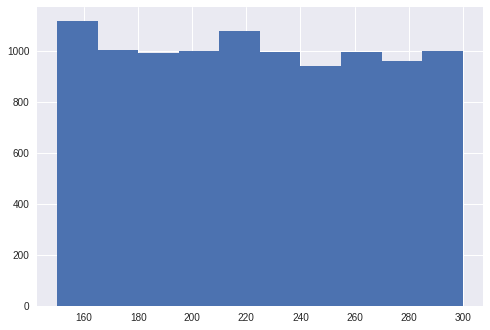

In [ ]:
plt.hist(training_shapes[:,1])

### Change training images

In [ ]:
def get_padding(image):
    max_w = 240    
    max_h = 240
    
    imsize = image.shape[1],image.shape[0]
    #imsize = image.size

    h_padding = (max_w - imsize[0]) / 2
    v_padding = (max_h - imsize[1]) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    
    padding = (int(t_pad), int(b_pad), int(l_pad), int(r_pad))
    
    return padding


#### Pad all of the training images, and turn to numpy

In [ ]:
train_X_natural_numpy = list()
for image in os.listdir(training_directory):
  
  io=cv2.cvtColor(cv2.imread(training_directory+image),cv2.COLOR_BGR2RGB)
  interp_method=PIL.Image.BICUBIC
  io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
  #print(np.subtract(shape,io.shape))
  #if io.shape[0]<=240 and io.shape[1]<=240:
  #  all_padding = get_padding(io)
  #  io = np.pad(io, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
  #  train_X_natural_numpy.append(io)
  #else:
  io = cv2.resize(io,(224,224))
  train_X_natural_numpy.append(io)
    

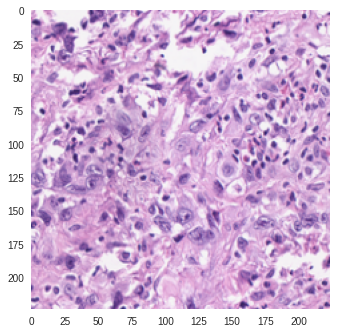

In [ ]:
plt.imshow(train_X_natural_numpy[8])
plt.grid(None)


### Sort Validation data 

In [ ]:
#Match the ground truth to the training image
X_image_strings_valid = list()
y_valid_strings = list()

for image_string in os.listdir(validation_directory+'/img'):
    X_image_strings_valid.append(os.path.join(validation_directory+'img',image_string))
for image_string in os.listdir(validation_directory+'/mask'):
    y_valid_strings.append(os.path.join(validation_directory+'mask',image_string))


In [ ]:
validation_data = {
    'larger_images'  : dict(),
    'smaller_images' : dict()
}

In [ ]:
def sort_data(file_loc_data, data_dictionary,directory):
  # Sort validation data 
  for i in range(len(file_loc_data)):
    # We need to sort if the image is large or not
    
    io=cv2.cvtColor(cv2.imread(file_loc_data[i]),cv2.COLOR_BGR2RGB)
    io_mask = cv2.cvtColor(cv2.imread(directory+'/mask'+file_loc_data[i][-7:]),cv2.COLOR_BGR2RGB)
    count = 0 
    interp_method=PIL.Image.BICUBIC
    io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
    io_mask = cv2.resize(io_mask,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above

    # If its a small image we want to pad and add to the smaller images 
    if io.shape[0] <= 240 and io.shape[1]<= 240:
      io_mask_map = map(int,[(io_mask == (0,64,128)).all(axis=-1).max(), (io_mask == (64,128,0)).all(axis=-1).max(), (io_mask == (243,152,0)).all(axis=-1).max()])
      io_mask_y_int = list(io_mask_map)
      all_padding = get_padding(io)
      io = np.pad(io, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      io_mask = np.pad(io_mask, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      data_dictionary['smaller_images'][file_loc_data[i][-6:]] = {'patch':io, 'mask':io_mask, 'label':io_mask_y_int} 
    else:
      # Create patches within the larger images
      patch_list = list()
      patch_list_mask = list()
      patch_y_values = list()
      #print(file_loc_data[i])
      sliding_window_patch_extractor = patchextraction.SlidingWindowPatchExtractor(
          input_img=io, # input image path, numpy array, or WSI object
          patch_size=(224, 224),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
      )
    
      
      sliding_window_patch_extractor_mask = patchextraction.SlidingWindowPatchExtractor(
          input_img=io_mask, # input image path, numpy array, or WSI object
          patch_size=(240, 240),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
          # stride of extracting patches, default is equal to patch_size
      )

      for patch in sliding_window_patch_extractor:
        patch_list.append(patch)

      for patch_mask in sliding_window_patch_extractor_mask:
        io_mask_map = map(int,[(patch_mask == (0,64,128)).all(axis=-1).max(), (patch_mask == (64,128,0)).all(axis=-1).max(), (patch_mask == (243,152,0)).all(axis=-1).max()])
        io_mask_y_int = list(io_mask_map)
        patch_y_values.append(io_mask_y_int)
        patch_list_mask.append(patch_mask)
      print(patch_y_values)
      data_dictionary['larger_images'][file_loc_data[i][-6:]] = {'patches':patch_list, 'masks':patch_list_mask, 'labels':patch_y_values} 

  return data_dictionary

In [ ]:
def sort_data_raw(file_loc_data, data_dictionary,directory):
  # Sort validation data ]
  masks = list()
  images = list()
  for i in range(len(file_loc_data)):
    # We need to sort if the image is large or not
    
    io=cv2.cvtColor(cv2.imread(file_loc_data[i]),cv2.COLOR_BGR2RGB)
    io_mask = cv2.cvtColor(cv2.imread(directory+'/mask'+file_loc_data[i][-7:]),cv2.COLOR_BGR2RGB)
    count = 0 
    interp_method=PIL.Image.BICUBIC
    io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
    io_mask = cv2.resize(io_mask,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above 
    masks.append(io_mask)
    images.append(io)
  return images,masks
    

In [ ]:
validation_data_images_raw = sort_data_raw(X_image_strings_valid,validation_data, validation_directory)

(-0.5, 474.5, 484.5, -0.5)

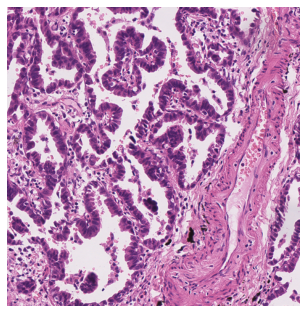

In [ ]:
plt.imshow(validation_data_images_raw[0][6])
plt.grid(False)
plt.axis('off')

(-0.5, 474.5, 484.5, -0.5)

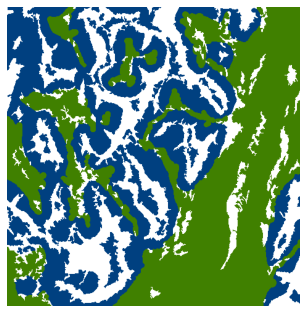

In [ ]:
plt.imshow(validation_data_images_raw[1][6])
plt.grid(False)
plt.axis('off')

In [ ]:
# 224 x 224 
def sort_data(file_loc_data, data_dictionary,directory):
  # Sort validation data 
  for i in range(len(file_loc_data)):
    # We need to sort if the image is large or not
    
    io=cv2.cvtColor(cv2.imread(file_loc_data[i]),cv2.COLOR_BGR2RGB)
    io_mask = cv2.cvtColor(cv2.imread(directory+'/mask'+file_loc_data[i][-7:]),cv2.COLOR_BGR2RGB)
    count = 0 
    interp_method=PIL.Image.BICUBIC
    io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
    io_mask = cv2.resize(io_mask,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above

    # If its a small image we want to pad and add to the smaller images 
    if io.shape[0] <= 224 and io.shape[1]<= 224:
      io_mask_map = map(int,[(io_mask == (0,64,128)).all(axis=-1).max(), (io_mask == (64,128,0)).all(axis=-1).max(), (io_mask == (243,152,0)).all(axis=-1).max()])
      io_mask_y_int = list(io_mask_map)
      #io_mask_map
      io = cv2.resize(io,(224,224))
      io_mask = cv2.resize(io_mask,(224,224))
      #all_padding = get_padding(io)
      #io = np.pad(io, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      #io_mask = np.pad(io_mask, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      data_dictionary['smaller_images'][file_loc_data[i][-6:]] = {'patch':io, 'mask':io_mask, 'label':io_mask_y_int} 
    else:
      # Create patches within the larger images
      patch_list = list()
      patch_list_mask = list()
      patch_y_values = list()
      #print(file_loc_data[i])
      sliding_window_patch_extractor = patchextraction.SlidingWindowPatchExtractor(
          input_img=io, # input image path, numpy array, or WSI object
          patch_size=(224, 224),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
      )
    
      
      sliding_window_patch_extractor_mask = patchextraction.SlidingWindowPatchExtractor(
          input_img=io_mask, # input image path, numpy array, or WSI object
          patch_size=(224, 224),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
          # stride of extracting patches, default is equal to patch_size
      )

      for patch in sliding_window_patch_extractor:
        patch_list.append(patch)

      for patch_mask in sliding_window_patch_extractor_mask:
        io_mask_map = map(int,[(patch_mask == (0,64,128)).all(axis=-1).max(), (patch_mask == (64,128,0)).all(axis=-1).max(), (patch_mask == (243,152,0)).all(axis=-1).max()])
        io_mask_y_int = list(io_mask_map)
        patch_y_values.append(io_mask_y_int)
        patch_list_mask.append(patch_mask)
      print(patch_y_values)
      data_dictionary['larger_images'][file_loc_data[i][-6:]] = {'patches':patch_list, 'masks':patch_list_mask, 'labels':patch_y_values} 

  return data_dictionary

In [ ]:
validation_data = sort_data(X_image_strings_valid,validation_data, validation_directory)

[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 0]]
[[0, 0, 1], [0, 0, 1]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[0, 1, 1], [0, 0, 1], [1, 1, 1], [0, 1, 1]]
[[1, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [0, 1, 0]]
[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0]]
[[1, 1, 0], [0, 1, 0], [1, 1, 0], [0, 0, 0]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0], [0

#### Validation Data Amalgamation

In [ ]:
validation_X_data = list()
validation_y_data = list()
validation_mask_data = list()

for key,item_dict in validation_data['smaller_images'].items():
  validation_X_data.append(item_dict['patch'])
  validation_y_data.append(item_dict['label'])
  validation_mask_data.append(item_dict['mask'])


for key,item_dict in validation_data['larger_images'].items():
  for i in range(len(item_dict['patches'])):
    validation_X_data.append(item_dict['patches'][i])
    validation_y_data.append(item_dict['labels'][i])
    validation_mask_data.append(item_dict['masks'][i])






In [ ]:
validation_data['larger_images']['02.png'].keys()

dict_keys(['patches', 'masks', 'labels'])

(-0.5, 223.5, 223.5, -0.5)

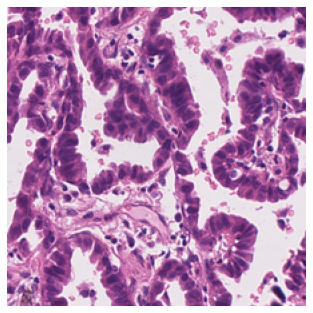

In [ ]:
plt.imshow(validation_data['larger_images']['06.png']['patches'][0])
plt.grid(False)
plt.axis('Off')

(-0.5, 223.5, 223.5, -0.5)

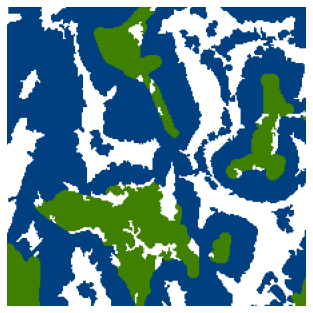

In [ ]:
plt.imshow(validation_data['larger_images']['06.png']['masks'][0])
plt.grid(False)
plt.axis('Off')

In [ ]:
validation_data['larger_images']['02.png']['labels'][0]

[0, 0, 1]

### Sort Testing data

In [ ]:
#Match the ground truth to the training image
X_image_strings_test = list()

for image_string in os.listdir(testing_directory+'/img'):
    X_image_strings_test.append(os.path.join(testing_directory+'img',image_string))

In [ ]:
testing_data = {
    'larger_images'  : dict(),
    'smaller_images' : dict()
}

In [ ]:
testing_data = sort_data(X_image_strings_test,testing_data, testing_directory)

[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[0, 0, 1], [0, 0, 1]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0

In [ ]:
test_X_data = list()
test_y_data = list()
test_mask_data = list()

for key,item_dict in testing_data['smaller_images'].items():
  test_X_data.append(item_dict['patch'])
  test_y_data.append(item_dict['label'])
  test_mask_data.append(item_dict['mask'])


for key,item_dict in testing_data['larger_images'].items():
  for i in range(len(item_dict['patches'])):
    test_X_data.append(item_dict['patches'][i])
    test_y_data.append(item_dict['labels'][i])
    test_mask_data.append(item_dict['masks'][i])


In [ ]:
len(test_X_data)

491

In [ ]:
len(validation_X_data)

258

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)


## Small Visualisations

In [ ]:
angle = random.randint(-30, 30)
      image = F.rotate(image,angle)
      mask = F.rotate(mask,angle)
    if random.random() >0.6:
      image = F.hflip(image)
      mask = F.hflip(mask)
    if random.random()>0.9:
      image = F.vflip(image)
      mask = F.vflip(mask)
    

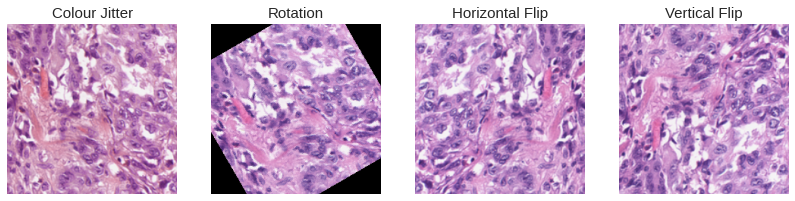

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(14,7))  # 1 row, 2 columns
grid='false'
ax[0].grid(False)
ax[0].set_title('Colour Jitter',fontsize = 15)
ax[0].imshow(color_jitter(Image.fromarray(train_X_natural_numpy[5])))
ax[0].axis('off')

ax[1].grid(False)
ax[1].axis('off')
ax[1].set_title('Rotation',fontsize = 15)
ax[1].imshow(F.rotate(Image.fromarray(train_X_natural_numpy[5]),30))
ax[2].grid(False)
ax[2].set_title('Horizontal Flip',fontsize = 15)
ax[2].axis('off')

ax[2].imshow(F.hflip(Image.fromarray(train_X_natural_numpy[5])))
ax[3].set_title('Vertical Flip',fontsize = 15)
ax[3].grid(False)
ax[3].axis('off')

ax[3].imshow(F.vflip(Image.fromarray(train_X_natural_numpy[5])))
plt.show()

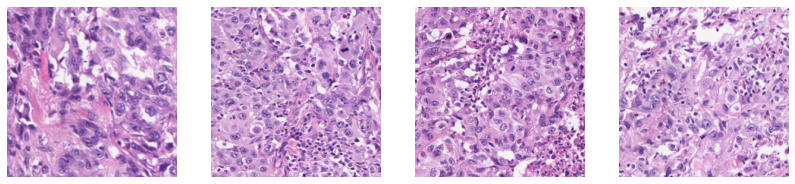

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(14,7))  # 1 row, 2 columns
grid='false'
ax[0].grid(False)
ax[0].imshow(Image.fromarray(train_X_natural_numpy[5]))
ax[0].axis('off')

ax[1].grid(False)
ax[1].axis('off')
ax[1].imshow(Image.fromarray(train_X_natural_numpy[6]))
ax[2].grid(False)
ax[2].axis('off')

ax[2].imshow(Image.fromarray(train_X_natural_numpy[7]))
ax[3].grid(False)
ax[3].axis('off')

ax[3].imshow(Image.fromarray(train_X_natural_numpy[8]))
plt.show()

In [ ]:
training_y[8]

[1, 1, 0]

## Cutmix Data Augmentation
Look at distribution for ability, to better pad and resize (sweetspot) and then cutmix. Further testing should be completed with the full test set and the thresholds tuned based upon that. 

In [ ]:
training_y = np.array(training_y)

In [ ]:
### Whole images single class data 

raw_images = list()
only_tumour_images_index = list()
only_stroma_images_index = list()
only_normal_images_index = list()


only_tumour_non_applicable_count = list()
only_stroma_non_applicable_count = list()
only_normal_non_applicable_count = list()

listing_dir = os.listdir(training_directory)
for i in range(len(listing_dir)):
   io=cv2.cvtColor(cv2.imread(training_directory+listing_dir[i]),cv2.COLOR_BGR2RGB)
   interp_method=PIL.Image.BICUBIC
   io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
   shape = io.shape
   raw_images.append(io)
   if all(training_y[i] == [1,0,0]):
      if shape[0]>= 224 and shape[1]>= 224:
        only_tumour_images_index.append(i)
      else:
        only_tumour_non_applicable_count.append(i)
   elif all(training_y[i] == [0,1,0]):
      if shape[0]>= 224 and shape[1]>= 224:
        only_stroma_images_index.append(i)
      else:
        only_stroma_non_applicable_count.append(i)
   elif all(training_y[i] == [0,0,1]):
      if shape[0]>= 224 and shape[1]>= 224:
        only_normal_images_index.append(i)
      else:
        only_normal_non_applicable_count.append(i)



In [ ]:
### Whole images single class data 

raw_images = list()

only_tumour = list()
only_stroma = list()
only_normal = list()

for i in range(len(train_X_natural_numpy)):
   
   if all(training_y[i] == [1,0,0]):
      only_tumour.append((train_X_natural_numpy[i],training_y[i]))
   elif all(training_y[i] == [0,1,0]):
      only_stroma.append((train_X_natural_numpy[i],training_y[i]))
   elif all(training_y[i] == [0,0,1]):
      only_normal.append((train_X_natural_numpy[i],training_y[i]))


In [ ]:
len(only_tumour)

1181

In [ ]:
len(only_stroma)

1680

In [ ]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """

    # Generate random bounding box inside area 
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

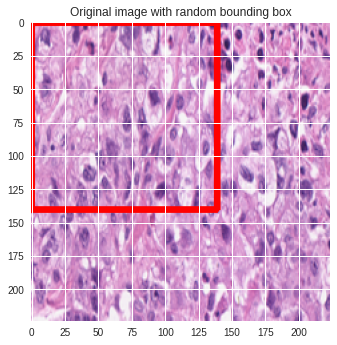

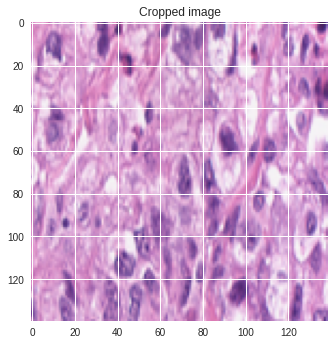

In [ ]:
image = train_X_natural_numpy[25]

# Crop a random bounding box
lamb = 0.3
size = image.shape
#padding = get_padding(image)
bbox = rand_bbox(size, lamb)

# Draw bounding box on the image
im = image.copy()
x1 = bbox[0]
y1 = bbox[1]
x2 = bbox[2]
y2 = bbox[3]
cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.imshow(im);
plt.title('Original image with random bounding box')
plt.show();

# Show cropped image
plt.imshow(image[y1:y2, x1:x2]);
plt.title('Cropped image')
plt.show()

In [ ]:
def generate_cutmix_image(edited_image, edited_image_label, raw_image, raw_image_label, beta):
    ## Generate cutmix image specifically for one image at a time. 
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    target_a = edited_image_label
    target_b = raw_image_label
    bbx1, bby1, bbx2, bby2 = rand_bbox(edited_image.shape, lam)
    raw_image = cv2.resize(raw_image,(240,240))
    image_batch_updated = edited_image.copy()
    image_batch_updated[bbx1:bbx2, bby1:bby2, :] = raw_image[bbx1:bbx2, bby1:bby2, :]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (edited_image.shape[0] * edited_image.shape[1]))
    label = target_a * lam + target_b * (1. - lam)

    
    return image_batch_updated, label

In [ ]:
def produce_all_cutmix_images(edited_indexs_tumour, edited_indexs_stroma, edited_indexs_normal, raw_indexs_tumour, raw_indexs_stroma, raw_indexs_normal):
  pairings = [(edited_indexs_tumour, raw_indexs_stroma), (edited_indexs_stroma, raw_indexs_normal), (edited_indexs_normal,raw_indexs_tumour)]
  cutmix_images = list()
  cutmix_labels = list()
  for pair in pairings:
    for i in range(len(pair[0])):
      cutmix_image, cutmix_label = generate_cutmix_image(pair[0][i][0],pair[0][i][1], pair[1][i][0],pair[1][i][1],1.0)
      cutmix_images.append(cutmix_image)
      cutmix_labels.append(cutmix_label)
  return cutmix_images, cutmix_labels


In [ ]:
total_cutmix = produce_all_cutmix_images(only_tumour[:400], only_stroma[:400], only_normal[:400], only_tumour[400:800], only_stroma[400:800], only_normal[400:800])

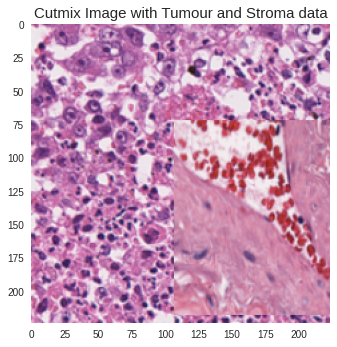

In [ ]:

plt.imshow(total_cutmix[0][5])
plt.grid(False)
plt.title('Cutmix Image with Tumour and Stroma data',fontsize = 15)
plt.show()

In [ ]:
total_cutmix[1][5]

array([0.65955835, 0.34044165, 0.        ])

In [ ]:
training_y = list(training_y)


In [ ]:
training_y.extend(total_cutmix[1])

In [ ]:
train_X_natural_numpy.extend(total_cutmix[0])

In [ ]:
len(train_X_natural_numpy)

11291

# Pipeline Creation

## Data Creation


In [ ]:
len(train_X_natural_numpy)

11291

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
# Create training dataset for multi-label classification
class WSSS4LUAD_train(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(train_X_natural_numpy)
    self.labels = np.array(training_y)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples


# Create training dataset for multi-label classification
class WSSS4LUAD_validation(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(validation_X_data)
    self.labels = np.array(validation_y_data)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples



In [ ]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:

from torchvision.transforms.transforms import ToPILImage
train_mean_li = [0.4116, 0.2823, 0.3788]
train_std_li = [0.3712, 0.2857, 0.3373]
valid_mean_li = [0.6121, 0.4388, 0.5688]
valid_std_li = [0.2239, 0.2414, 0.1998]
train_transforms = transforms.Compose([
      transforms.ToPILImage(), 
      transforms.ColorJitter(brightness=0.4),  
      transforms.RandomRotation(degrees=45),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.05),
      transforms.ToTensor(),
      #normalize
])

valid_transforms = transforms.Compose([
      transforms.ToTensor(),
      #normalize
      #transforms.Normalize(torch.Tensor(valid_mean_li), torch.Tensor(valid_std_li))

])

In [ ]:
WSSS4LUAD_dataset_train = WSSS4LUAD_train(train_transforms)
dataloader_WSSS4LUAD_train = DataLoader(dataset = WSSS4LUAD_dataset_train, batch_size = 32, shuffle = True)
WSSS4LUAD_dataset_valid = WSSS4LUAD_validation(valid_transforms)
dataloader_WSSS4LUAD_valid = DataLoader(dataset = WSSS4LUAD_dataset_valid, batch_size = 32, shuffle = False)


In [ ]:
len(train_X_natural_numpy)

11291

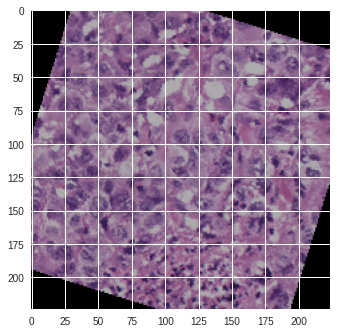

In [ ]:
imshow(WSSS4LUAD_dataset_train.__getitem__(0)['image'])

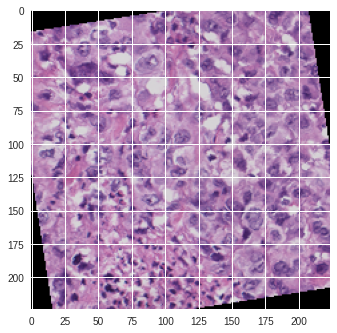

In [ ]:
imshow(WSSS4LUAD_dataset_train.__getitem__(0)['image'])

##### Get mean and Standard Deviation

In [ ]:
def get_mean_and_std(loader):
  mean = 0.
  std = 0.
  total_images_count = 0
  for images, _ in loader:
    image_count_in_a_batch = images.size(0)
    images = images.view(image_count_in_a_batch, images.size(1),-1)
    mean += images.mean(2).sum(0)

    std += images.std(2).sum(0)
    total_images_count += image_count_in_a_batch


  mean /= total_images_count
  std /= total_images_count

  return mean, std

In [ ]:
train_mean, train_std = get_mean_and_std(dataloader_WSSS4LUAD_train)
valid_mean, valid_std = get_mean_and_std(dataloader_WSSS4LUAD_valid)


AttributeError: ignored

In [ ]:
valid_std

tensor([0.2239, 0.2414, 0.1998])

In [ ]:
train_mean

tensor([0.4116, 0.2823, 0.3788])

#### Build Dataset

In [ ]:
def label_to_histogram(labels):
  total = list()
  for item in labels:
    if all(item == [1,0,0]):
      total.append('Tumour')
    if all(item == [1,1,0]):
      total.append('Tumour-stroma')
    if all(item == [1,1,1]):
      total.append('Tumour-stroma-normal')
    if all(item == [0,1,1]):
      total.append('stroma-normal')
    if all(item == [0,1,0]):
      total.append('stroma')
    if all(item == [0,0,1]):
      total.append('normal')
    if all(item == [1,0,1]):
      total.append('Tumour-normal')
  return total
    

In [ ]:
labels_histogram = label_to_histogram(WSSS4LUAD_dataset_train.labels)

In [ ]:
labels_histogram_v = label_to_histogram(WSSS4LUAD_dataset_valid.labels)

In [ ]:
labels_histogram_t = label_to_histogram(WSSS4LUAD_dataset_test.labels)

NameError: ignored

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]

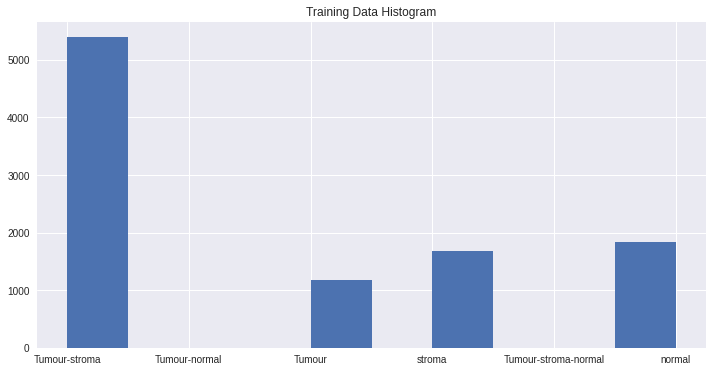

In [ ]:
plt.hist(labels_histogram)
plt.title('Training Data Histogram')
plt.show()

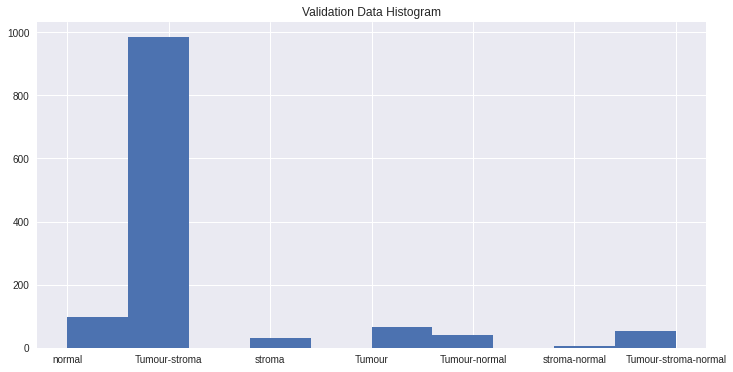

In [ ]:

plt.hist(labels_histogram_v)
plt.title('Validation Data Histogram')
plt.show()

#### Using original Training set 

In [ ]:
len(validation_X_data)

1282

In [ ]:
### train valid datasets, just from the original training dataset 
# Create training dataset for multi-label classification

X_train_train, X_valid_train, y_train_train, y_valid_train = train_test_split(train_X_natural_numpy, training_y, test_size=0.15, random_state=42)
class WSSS4LUAD_train(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(X_train_train)
    self.labels = np.array(y_train_train)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples


# Create training dataset for multi-label classification
class WSSS4LUAD_validation(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(X_valid_train)
    self.labels = np.array(y_valid_train)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples

In [ ]:
WSSS4LUAD_dataset_train = WSSS4LUAD_train(train_transforms)
dataloader_WSSS4LUAD_train = DataLoader(dataset = WSSS4LUAD_dataset_train, batch_size = 32, shuffle = True)


In [ ]:
WSSS4LUAD_dataset_valid = WSSS4LUAD_validation(valid_transforms)
dataloader_WSSS4LUAD_valid = DataLoader(dataset = WSSS4LUAD_dataset_valid, batch_size = 32, shuffle = False)


In [ ]:
labels_histogram = label_to_histogram(WSSS4LUAD_dataset_train.labels)

NameError: ignored

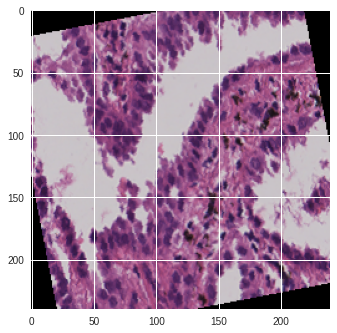

In [ ]:
imshow(WSSS4LUAD_dataset_train.__getitem__(365 )['image'])

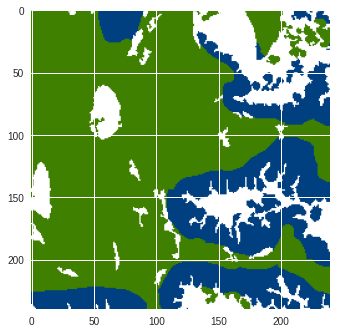

In [ ]:
plt.imshow(validation_mask_data[365])

In [ ]:
WSSS4LUAD_dataset_valid.__getitem__(388)['label']

tensor([1., 1., 0.], dtype=torch.float64)

In [ ]:
labels_histogram_v = label_to_histogram(WSSS4LUAD_dataset_valid.labels)

NameError: ignored

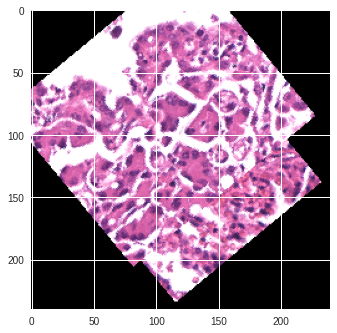

In [ ]:
imshow(WSSS4LUAD_dataset_train.__getitem__(0)['image'])

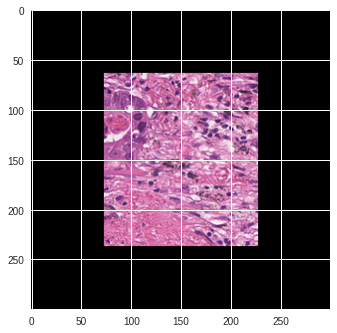

In [ ]:
imshow(WSSS4LUAD_dataset_valid.__getitem__(25)['image'])

### Build Multi-label Classifier

In [ ]:
def model_res(model):
  for param in model.parameters():
    param.requires_grad = True
  model.fc = nn.Linear(512,3)
  return model

In [ ]:
LUAD_classifier = model_res(torchvision.models.resnet34()).to(device)

In [ ]:
LUAD_classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### EfficientNet Model

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
def model_config(model):
  
  for param in model.parameters():
    param.requires_grad = True
  model.classifier.fc = nn.Linear(1280,3)
  return model

In [ ]:
def model_config_50(model):
  
  for param in model.parameters():
    param.requires_grad = True
  model.fc = nn.Linear(2048,3)
  return model

In [ ]:
resnet18_LUAD = model_res(torchvision.models.resnet18(pretrained=True)).to(device)
resnet34_LUAD = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
resnet50_LUAD = model_config_50(torchvision.models.resnet50(pretrained=True)).to(device)

efficientnet_LUAD = model_config(torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)).to(device)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
total_models = [resnet18_LUAD, resnet34_LUAD, resnet50_LUAD,efficientnet_LUAD]
total_model_names = ['resnet18_LUAD', 'resnet34_LUAD','resnet50_LUAD', 'efficientnet_LUAD']

In [ ]:
len(train_X_natural_numpy)

11291

### Training and Validation

In [ ]:
dataloaders = {
    'train':dataloader_WSSS4LUAD_train,
    'val': dataloader_WSSS4LUAD_valid
}

dataset_sizes = {'train':len(dataloader_WSSS4LUAD_train),
                 'val':len(dataloader_WSSS4LUAD_valid)
                 }

In [ ]:
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        target = target.to(torch.float32)

        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [ ]:
# validation function
def validate(model, dataloader, criterion, val_data, device,hyperparams):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    tumour_correct = 0.0
    stroma_correct = 0.0
    normal_correct = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            
            
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            target = target.to(torch.float32)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()

            # Gaining accuracy 
            outputs[outputs >= 0.5] = 1
            outputs[:,0][outputs[:,0]>= 0.5] = 1
            outputs[:,0][outputs[:,0]< 0.5] = 0

            outputs[:,1][outputs[:,1]>= 0.5] = 1
            outputs[:,1][outputs[:,1]< 0.5] = 0

            outputs[:,2][outputs[:,2]>= hyperparams[1]] = 1
            outputs[:,2][outputs[:,2]< hyperparams[1]] = 0
            
            tumour_correct += (outputs[:,0] == target[:,0]).sum()
            stroma_correct += (outputs[:,1] == target[:,1]).sum()
            normal_correct += (outputs[:,2] == target[:,2]).sum()

       
        val_loss = val_running_loss / counter
        val_acc_tumour = (tumour_correct / len(val_data)) * 100
        val_acc_stroma = (stroma_correct / len(val_data)) * 100
        val_acc_normal = (normal_correct / len(val_data)) * 100
        total_val_acc = ((tumour_correct + stroma_correct + normal_correct) / (len(val_data)*3))*100
        print('val_acc_tumour:' + str(val_acc_tumour))
        print('val_acc_stroma:' + str(val_acc_stroma))
        print('val_acc_normal:' + str(val_acc_normal))
        return val_loss, val_acc_tumour, val_acc_stroma, val_acc_normal, total_val_acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
torch.cuda.empty_cache()


In [ ]:

grid_search = [(0.001, 0.5),(0.001, 0.45),(0.001, 0.4),(0.001, 0.35), (0.005, 0.5),(0.005, 0.45), (0.005, 0.4), (0.005, 0.35), (0.01, 0.5),(0.01, 0.45), (0.01, 0.4), (0.01, 0.35)]
torch.manual_seed(0)


In [ ]:
# start the training and validation

def full_training_and_val(model,hyperparams,model_name):
  #luad_model = luad_model.to(device)
  criterion = nn.BCELoss()

  optimizer = torch.optim.Adam(model.parameters(),lr=hyperparams[0])

  epochs = 25
  train_loss = []
  valid_loss = []
  tumour_acc = []
  stroma_acc = []
  normal_acc = []
  total_acc = []
  best_loss = float('inf')
  for epoch in range(epochs):
      print(f"Epoch {epoch+1} of {epochs}")
      train_epoch_loss = train(
          model, dataloaders['train'], optimizer, criterion, WSSS4LUAD_dataset_train, device
      )
      valid_epoch_metrics = validate(
          model, dataloaders['val'], criterion, WSSS4LUAD_dataset_valid, device, hyperparams
      )

      if best_loss > valid_epoch_metrics[0]:
        best_loss = valid_epoch_metrics[0]
        torch.save({
              'epoch': epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': criterion,
              }, '/content/drive/MyDrive/'+model_name+'_withcutmix.pth')



      train_loss.append(train_epoch_loss)
      valid_loss.append(valid_epoch_metrics[0])
      tumour_acc.append(valid_epoch_metrics[1])
      stroma_acc.append(valid_epoch_metrics[2])
      normal_acc.append(valid_epoch_metrics[3])
      total_acc.append(valid_epoch_metrics[4])
      print(f"Train Loss: {train_epoch_loss:.4f}")
      print(f'Val Loss: {valid_epoch_metrics[0]:.4f}')
      print(f'Val Accuracy: {valid_epoch_metrics[4]:.4f}')

  total_dict = {'training_loss' : train_loss,
                'validation_loss' : valid_loss,
                'tumour_acc' : tumour_acc,
                'stroma_acc' : stroma_acc,
                'normal_acc' : normal_acc,
                'total_acc' : total_acc
                }
  return total_dict

In [ ]:
full_training_and_val(LUAD_classifier,(0.001,0.45))

Epoch 1 of 20
Training


353it [00:42,  8.31it/s]


Validating


47it [00:02, 22.35it/s]                        


val_acc_tumour:tensor(82.0704, device='cuda:0')
val_acc_stroma:tensor(80.6495, device='cuda:0')
val_acc_normal:tensor(89.0392, device='cuda:0')
Train Loss: 0.4930
Val Loss: 0.3684
Val Accuracy: 83.9197
Epoch 2 of 20
Training


353it [00:42,  8.34it/s]


Validating


47it [00:02, 23.09it/s]                        


val_acc_tumour:tensor(76.4547, device='cuda:0')
val_acc_stroma:tensor(64.1407, device='cuda:0')
val_acc_normal:tensor(70.3654, device='cuda:0')
Train Loss: 0.4280
Val Loss: 0.5407
Val Accuracy: 70.3203
Epoch 3 of 20
Training


353it [00:42,  8.40it/s]


Validating


47it [00:01, 23.91it/s]                        


val_acc_tumour:tensor(59.6076, device='cuda:0')
val_acc_stroma:tensor(67.8620, device='cuda:0')
val_acc_normal:tensor(73.0041, device='cuda:0')
Train Loss: 0.3865
Val Loss: 0.8266
Val Accuracy: 66.8245
Epoch 4 of 20
Training


353it [00:41,  8.43it/s]


Validating


47it [00:02, 23.12it/s]                        


val_acc_tumour:tensor(71.9892, device='cuda:0')
val_acc_stroma:tensor(76.8606, device='cuda:0')
val_acc_normal:tensor(82.6793, device='cuda:0')
Train Loss: 0.3531
Val Loss: 0.4789
Val Accuracy: 77.1764
Epoch 5 of 20
Training


353it [00:41,  8.41it/s]


Validating


47it [00:01, 23.56it/s]                        


val_acc_tumour:tensor(88.5656, device='cuda:0')
val_acc_stroma:tensor(76.9283, device='cuda:0')
val_acc_normal:tensor(81.7997, device='cuda:0')
Train Loss: 0.3328
Val Loss: 0.4378
Val Accuracy: 82.4312
Epoch 6 of 20
Training


353it [00:41,  8.42it/s]


Validating


47it [00:02, 22.82it/s]                        


val_acc_tumour:tensor(64.1407, device='cuda:0')
val_acc_stroma:tensor(80.3112, device='cuda:0')
val_acc_normal:tensor(90.0541, device='cuda:0')
Train Loss: 0.3112
Val Loss: 0.5106
Val Accuracy: 78.1687
Epoch 7 of 20
Training


353it [00:41,  8.44it/s]


Validating


47it [00:02, 23.20it/s]                        


val_acc_tumour:tensor(67.0501, device='cuda:0')
val_acc_stroma:tensor(78.9580, device='cuda:0')
val_acc_normal:tensor(88.6333, device='cuda:0')
Train Loss: 0.3007
Val Loss: 0.5786
Val Accuracy: 78.2138
Epoch 8 of 20
Training


353it [00:41,  8.44it/s]


Validating


47it [00:01, 23.69it/s]                        


val_acc_tumour:tensor(79.6346, device='cuda:0')
val_acc_stroma:tensor(83.3559, device='cuda:0')
val_acc_normal:tensor(91.6103, device='cuda:0')
Train Loss: 0.2815
Val Loss: 0.4034
Val Accuracy: 84.8669
Epoch 9 of 20
Training


353it [00:41,  8.41it/s]


Validating


47it [00:02, 23.46it/s]                        


val_acc_tumour:tensor(83.1529, device='cuda:0')
val_acc_stroma:tensor(73.4777, device='cuda:0')
val_acc_normal:tensor(90.3248, device='cuda:0')
Train Loss: 0.2730
Val Loss: 0.3944
Val Accuracy: 82.3185
Epoch 10 of 20
Training


353it [00:41,  8.46it/s]


Validating


47it [00:01, 23.57it/s]                        


val_acc_tumour:tensor(74.2896, device='cuda:0')
val_acc_stroma:tensor(78.6874, device='cuda:0')
val_acc_normal:tensor(82.8146, device='cuda:0')
Train Loss: 0.2655
Val Loss: 0.4490
Val Accuracy: 78.5972
Epoch 11 of 20
Training


353it [00:41,  8.44it/s]


Validating


47it [00:01, 23.84it/s]                        


val_acc_tumour:tensor(82.0027, device='cuda:0')
val_acc_stroma:tensor(83.8295, device='cuda:0')
val_acc_normal:tensor(92.3545, device='cuda:0')
Train Loss: 0.2614
Val Loss: 0.3606
Val Accuracy: 86.0622
Epoch 12 of 20
Training


353it [00:41,  8.43it/s]


Validating


47it [00:02, 23.43it/s]                        


val_acc_tumour:tensor(70.8390, device='cuda:0')
val_acc_stroma:tensor(84.1001, device='cuda:0')
val_acc_normal:tensor(90.5277, device='cuda:0')
Train Loss: 0.2517
Val Loss: 0.4799
Val Accuracy: 81.8223
Epoch 13 of 20
Training


353it [00:41,  8.45it/s]


Validating


47it [00:01, 23.62it/s]                        


val_acc_tumour:tensor(67.2530, device='cuda:0')
val_acc_stroma:tensor(84.1678, device='cuda:0')
val_acc_normal:tensor(92.9635, device='cuda:0')
Train Loss: 0.2509
Val Loss: 0.4858
Val Accuracy: 81.4614
Epoch 14 of 20
Training


353it [00:41,  8.42it/s]


Validating


47it [00:02, 23.30it/s]                        


val_acc_tumour:tensor(78.8227, device='cuda:0')
val_acc_stroma:tensor(84.0325, device='cuda:0')
val_acc_normal:tensor(92.6928, device='cuda:0')
Train Loss: 0.2459
Val Loss: 0.3734
Val Accuracy: 85.1827
Epoch 15 of 20
Training


353it [00:41,  8.44it/s]


Validating


47it [00:02, 23.27it/s]                        


val_acc_tumour:tensor(73.2747, device='cuda:0')
val_acc_stroma:tensor(85.5210, device='cuda:0')
val_acc_normal:tensor(92.7605, device='cuda:0')
Train Loss: 0.2385
Val Loss: 0.4769
Val Accuracy: 83.8521
Epoch 16 of 20
Training


353it [00:41,  8.43it/s]


Validating


47it [00:02, 22.78it/s]                        


val_acc_tumour:tensor(84.5737, device='cuda:0')
val_acc_stroma:tensor(85.5210, device='cuda:0')
val_acc_normal:tensor(91.8133, device='cuda:0')
Train Loss: 0.2351
Val Loss: 0.3132
Val Accuracy: 87.3027
Epoch 17 of 20
Training


353it [00:41,  8.41it/s]


Validating


47it [00:02, 22.96it/s]                        


val_acc_tumour:tensor(57.4425, device='cuda:0')
val_acc_stroma:tensor(82.3410, device='cuda:0')
val_acc_normal:tensor(87.2124, device='cuda:0')
Train Loss: 0.2281
Val Loss: 0.5130
Val Accuracy: 75.6653
Epoch 18 of 20
Training


353it [00:41,  8.46it/s]


Validating


47it [00:01, 23.87it/s]                        


val_acc_tumour:tensor(91.0690, device='cuda:0')
val_acc_stroma:tensor(70.5007, device='cuda:0')
val_acc_normal:tensor(86.0622, device='cuda:0')
Train Loss: 0.2284
Val Loss: 0.4943
Val Accuracy: 82.5440
Epoch 19 of 20
Training


353it [00:41,  8.43it/s]


Validating


47it [00:02, 23.47it/s]                        


val_acc_tumour:tensor(82.0704, device='cuda:0')
val_acc_stroma:tensor(86.6712, device='cuda:0')
val_acc_normal:tensor(95.7375, device='cuda:0')
Train Loss: 0.2215
Val Loss: 0.3616
Val Accuracy: 88.1597
Epoch 20 of 20
Training


353it [00:41,  8.43it/s]


Validating


47it [00:02, 23.21it/s]                        


val_acc_tumour:tensor(86.7388, device='cuda:0')
val_acc_stroma:tensor(84.9797, device='cuda:0')
val_acc_normal:tensor(93.5724, device='cuda:0')
Train Loss: 0.2141
Val Loss: 0.2924
Val Accuracy: 88.4303


{'normal_acc': [tensor(89.0392, device='cuda:0'),
  tensor(70.3654, device='cuda:0'),
  tensor(73.0041, device='cuda:0'),
  tensor(82.6793, device='cuda:0'),
  tensor(81.7997, device='cuda:0'),
  tensor(90.0541, device='cuda:0'),
  tensor(88.6333, device='cuda:0'),
  tensor(91.6103, device='cuda:0'),
  tensor(90.3248, device='cuda:0'),
  tensor(82.8146, device='cuda:0'),
  tensor(92.3545, device='cuda:0'),
  tensor(90.5277, device='cuda:0'),
  tensor(92.9635, device='cuda:0'),
  tensor(92.6928, device='cuda:0'),
  tensor(92.7605, device='cuda:0'),
  tensor(91.8133, device='cuda:0'),
  tensor(87.2124, device='cuda:0'),
  tensor(86.0622, device='cuda:0'),
  tensor(95.7375, device='cuda:0'),
  tensor(93.5724, device='cuda:0')],
 'stroma_acc': [tensor(80.6495, device='cuda:0'),
  tensor(64.1407, device='cuda:0'),
  tensor(67.8620, device='cuda:0'),
  tensor(76.8606, device='cuda:0'),
  tensor(76.9283, device='cuda:0'),
  tensor(80.3112, device='cuda:0'),
  tensor(78.9580, device='cuda:0'),

In [ ]:
for i in range(len(grid_search)):
  efficientnet_LUAD = model_config(torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)).to(device)
  full_training_and_val(efficientnet_LUAD, grid_search[i])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch 1 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.92it/s]                        


val_acc_tumour:tensor(85.3354, device='cuda:0')
val_acc_stroma:tensor(80.1872, device='cuda:0')
val_acc_normal:tensor(89.3136, device='cuda:0')
Train Loss: 0.2434
Val Loss: 0.3686
Val Accuracy: 84.9454
Epoch 2 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.17it/s]                        


val_acc_tumour:tensor(86.5055, device='cuda:0')
val_acc_stroma:tensor(85.3354, device='cuda:0')
val_acc_normal:tensor(91.0296, device='cuda:0')
Train Loss: 0.1859
Val Loss: 0.3956
Val Accuracy: 87.6235
Epoch 3 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.17it/s]                        


val_acc_tumour:tensor(86.1154, device='cuda:0')
val_acc_stroma:tensor(80.8892, device='cuda:0')
val_acc_normal:tensor(92.4337, device='cuda:0')
Train Loss: 0.1676
Val Loss: 0.4184
Val Accuracy: 86.4795
Epoch 4 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 21.99it/s]                        


val_acc_tumour:tensor(94.1498, device='cuda:0')
val_acc_stroma:tensor(72.6989, device='cuda:0')
val_acc_normal:tensor(90.9516, device='cuda:0')
Train Loss: 0.1592
Val Loss: 0.4304
Val Accuracy: 85.9334
Epoch 5 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.53it/s]                        


val_acc_tumour:tensor(91.0296, device='cuda:0')
val_acc_stroma:tensor(86.1154, device='cuda:0')
val_acc_normal:tensor(93.8378, device='cuda:0')
Train Loss: 0.1533
Val Loss: 0.3226
Val Accuracy: 90.3276
Epoch 6 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.51it/s]                        


val_acc_tumour:tensor(90.6396, device='cuda:0')
val_acc_stroma:tensor(88.9236, device='cuda:0')
val_acc_normal:tensor(94.1498, device='cuda:0')
Train Loss: 0.1461
Val Loss: 0.2870
Val Accuracy: 91.2376
Epoch 7 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 21.81it/s]                        


val_acc_tumour:tensor(86.9735, device='cuda:0')
val_acc_stroma:tensor(81.5133, device='cuda:0')
val_acc_normal:tensor(90.0156, device='cuda:0')
Train Loss: 0.1424
Val Loss: 0.7681
Val Accuracy: 86.1674
Epoch 8 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.65it/s]                        


val_acc_tumour:tensor(92.3557, device='cuda:0')
val_acc_stroma:tensor(88.7676, device='cuda:0')
val_acc_normal:tensor(92.6677, device='cuda:0')
Train Loss: 0.1353
Val Loss: 0.3635
Val Accuracy: 91.2636
Epoch 9 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.50it/s]                        


val_acc_tumour:tensor(88.7676, device='cuda:0')
val_acc_stroma:tensor(77.7691, device='cuda:0')
val_acc_normal:tensor(89.4696, device='cuda:0')
Train Loss: 0.1335
Val Loss: 0.3932
Val Accuracy: 85.3354
Epoch 10 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.76it/s]                        


val_acc_tumour:tensor(90.3276, device='cuda:0')
val_acc_stroma:tensor(86.5055, device='cuda:0')
val_acc_normal:tensor(91.0296, device='cuda:0')
Train Loss: 0.1313
Val Loss: 0.3765
Val Accuracy: 89.2876
Epoch 11 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.42it/s]                        


val_acc_tumour:tensor(88.2995, device='cuda:0')
val_acc_stroma:tensor(86.5055, device='cuda:0')
val_acc_normal:tensor(93.9938, device='cuda:0')
Train Loss: 0.1229
Val Loss: 0.4330
Val Accuracy: 89.5996
Epoch 12 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.54it/s]                        


val_acc_tumour:tensor(89.8596, device='cuda:0')
val_acc_stroma:tensor(73.9470, device='cuda:0')
val_acc_normal:tensor(94.4618, device='cuda:0')
Train Loss: 0.1216
Val Loss: 0.4327
Val Accuracy: 86.0894
Epoch 13 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.20it/s]                        


val_acc_tumour:tensor(91.9657, device='cuda:0')
val_acc_stroma:tensor(86.5835, device='cuda:0')
val_acc_normal:tensor(91.6537, device='cuda:0')
Train Loss: 0.1179
Val Loss: 0.4041
Val Accuracy: 90.0676
Epoch 14 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.37it/s]                        


val_acc_tumour:tensor(87.7535, device='cuda:0')
val_acc_stroma:tensor(83.3073, device='cuda:0')
val_acc_normal:tensor(91.8097, device='cuda:0')
Train Loss: 0.1173
Val Loss: 0.3687
Val Accuracy: 87.6235
Epoch 15 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.31it/s]                        


val_acc_tumour:tensor(89.2356, device='cuda:0')
val_acc_stroma:tensor(85.2574, device='cuda:0')
val_acc_normal:tensor(91.6537, device='cuda:0')
Train Loss: 0.1181
Val Loss: 0.3766
Val Accuracy: 88.7155
Epoch 16 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 21.72it/s]                        


val_acc_tumour:tensor(93.6817, device='cuda:0')
val_acc_stroma:tensor(87.6755, device='cuda:0')
val_acc_normal:tensor(94.3058, device='cuda:0')
Train Loss: 0.1093
Val Loss: 0.2942
Val Accuracy: 91.8877
Epoch 17 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.24it/s]                        


val_acc_tumour:tensor(91.8877, device='cuda:0')
val_acc_stroma:tensor(84.8674, device='cuda:0')
val_acc_normal:tensor(93.2137, device='cuda:0')
Train Loss: 0.1088
Val Loss: 0.3619
Val Accuracy: 89.9896
Epoch 18 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.20it/s]                        


val_acc_tumour:tensor(91.4197, device='cuda:0')
val_acc_stroma:tensor(82.6833, device='cuda:0')
val_acc_normal:tensor(92.8237, device='cuda:0')
Train Loss: 0.1064
Val Loss: 0.3725
Val Accuracy: 88.9756
Epoch 19 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.79it/s]                        


val_acc_tumour:tensor(92.1217, device='cuda:0')
val_acc_stroma:tensor(85.8034, device='cuda:0')
val_acc_normal:tensor(91.3417, device='cuda:0')
Train Loss: 0.1055
Val Loss: 0.4080
Val Accuracy: 89.7556
Epoch 20 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.65it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(89.0796, device='cuda:0')
val_acc_stroma:tensor(83.0733, device='cuda:0')
val_acc_normal:tensor(93.6037, device='cuda:0')
Train Loss: 0.1112
Val Loss: 0.3337
Val Accuracy: 88.5855
Epoch 1 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.19it/s]                        


val_acc_tumour:tensor(86.8175, device='cuda:0')
val_acc_stroma:tensor(83.4633, device='cuda:0')
val_acc_normal:tensor(91.4977, device='cuda:0')
Train Loss: 0.2469
Val Loss: 0.3703
Val Accuracy: 87.2595
Epoch 2 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.00it/s]                        


val_acc_tumour:tensor(93.6817, device='cuda:0')
val_acc_stroma:tensor(77.3791, device='cuda:0')
val_acc_normal:tensor(92.3557, device='cuda:0')
Train Loss: 0.1867
Val Loss: 0.3238
Val Accuracy: 87.8055
Epoch 3 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.81it/s]                        


val_acc_tumour:tensor(88.7676, device='cuda:0')
val_acc_stroma:tensor(80.4992, device='cuda:0')
val_acc_normal:tensor(91.7317, device='cuda:0')
Train Loss: 0.1655
Val Loss: 0.3377
Val Accuracy: 86.9995
Epoch 4 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.35it/s]                        


val_acc_tumour:tensor(88.5335, device='cuda:0')
val_acc_stroma:tensor(81.6693, device='cuda:0')
val_acc_normal:tensor(90.2496, device='cuda:0')
Train Loss: 0.1591
Val Loss: 0.6991
Val Accuracy: 86.8175
Epoch 5 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.73it/s]                        


val_acc_tumour:tensor(90.9516, device='cuda:0')
val_acc_stroma:tensor(85.1794, device='cuda:0')
val_acc_normal:tensor(90.7176, device='cuda:0')
Train Loss: 0.1504
Val Loss: 0.3226
Val Accuracy: 88.9496
Epoch 6 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.49it/s]                        


val_acc_tumour:tensor(90.0936, device='cuda:0')
val_acc_stroma:tensor(86.7395, device='cuda:0')
val_acc_normal:tensor(91.1856, device='cuda:0')
Train Loss: 0.1421
Val Loss: 0.3052
Val Accuracy: 89.3396
Epoch 7 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.96it/s]                        


val_acc_tumour:tensor(91.9657, device='cuda:0')
val_acc_stroma:tensor(66.7707, device='cuda:0')
val_acc_normal:tensor(92.7457, device='cuda:0')
Train Loss: 0.1384
Val Loss: 0.6053
Val Accuracy: 83.8274
Epoch 8 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.60it/s]                        


val_acc_tumour:tensor(91.2636, device='cuda:0')
val_acc_stroma:tensor(87.4415, device='cuda:0')
val_acc_normal:tensor(91.4977, device='cuda:0')
Train Loss: 0.1316
Val Loss: 0.3357
Val Accuracy: 90.0676
Epoch 9 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 21.98it/s]                        


val_acc_tumour:tensor(94.4618, device='cuda:0')
val_acc_stroma:tensor(75.8970, device='cuda:0')
val_acc_normal:tensor(93.0577, device='cuda:0')
Train Loss: 0.1336
Val Loss: 0.3593
Val Accuracy: 87.8055
Epoch 10 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.90it/s]                        


val_acc_tumour:tensor(86.3494, device='cuda:0')
val_acc_stroma:tensor(81.5133, device='cuda:0')
val_acc_normal:tensor(91.0296, device='cuda:0')
Train Loss: 0.1302
Val Loss: 0.4920
Val Accuracy: 86.2974
Epoch 11 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.66it/s]                        


val_acc_tumour:tensor(91.6537, device='cuda:0')
val_acc_stroma:tensor(82.0593, device='cuda:0')
val_acc_normal:tensor(92.9017, device='cuda:0')
Train Loss: 0.1280
Val Loss: 0.2889
Val Accuracy: 88.8716
Epoch 12 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 23.06it/s]                        


val_acc_tumour:tensor(92.8237, device='cuda:0')
val_acc_stroma:tensor(88.9236, device='cuda:0')
val_acc_normal:tensor(92.6677, device='cuda:0')
Train Loss: 0.1203
Val Loss: 0.3390
Val Accuracy: 91.4717
Epoch 13 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.24it/s]                        


val_acc_tumour:tensor(84.9454, device='cuda:0')
val_acc_stroma:tensor(80.9672, device='cuda:0')
val_acc_normal:tensor(89.7816, device='cuda:0')
Train Loss: 0.1189
Val Loss: 0.4517
Val Accuracy: 85.2314
Epoch 14 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.72it/s]                        


val_acc_tumour:tensor(92.7457, device='cuda:0')
val_acc_stroma:tensor(86.3494, device='cuda:0')
val_acc_normal:tensor(92.7457, device='cuda:0')
Train Loss: 0.1156
Val Loss: 0.3720
Val Accuracy: 90.6136
Epoch 15 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.11it/s]                        


val_acc_tumour:tensor(93.6037, device='cuda:0')
val_acc_stroma:tensor(83.0733, device='cuda:0')
val_acc_normal:tensor(92.9017, device='cuda:0')
Train Loss: 0.1216
Val Loss: 0.3720
Val Accuracy: 89.8596
Epoch 16 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.31it/s]                        


val_acc_tumour:tensor(91.8097, device='cuda:0')
val_acc_stroma:tensor(77.0671, device='cuda:0')
val_acc_normal:tensor(91.9657, device='cuda:0')
Train Loss: 0.1087
Val Loss: 0.3969
Val Accuracy: 86.9475
Epoch 17 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.59it/s]                        


val_acc_tumour:tensor(91.3417, device='cuda:0')
val_acc_stroma:tensor(86.5835, device='cuda:0')
val_acc_normal:tensor(92.5897, device='cuda:0')
Train Loss: 0.1131
Val Loss: 0.3785
Val Accuracy: 90.1716
Epoch 18 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.04it/s]                        


val_acc_tumour:tensor(88.4555, device='cuda:0')
val_acc_stroma:tensor(83.8534, device='cuda:0')
val_acc_normal:tensor(91.4977, device='cuda:0')
Train Loss: 0.1088
Val Loss: 0.5121
Val Accuracy: 87.9355
Epoch 19 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.00it/s]                        


val_acc_tumour:tensor(86.7395, device='cuda:0')
val_acc_stroma:tensor(79.9532, device='cuda:0')
val_acc_normal:tensor(88.2995, device='cuda:0')
Train Loss: 0.1066
Val Loss: 0.5853
Val Accuracy: 84.9974
Epoch 20 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.69it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(90.7956, device='cuda:0')
val_acc_stroma:tensor(83.4633, device='cuda:0')
val_acc_normal:tensor(94.4618, device='cuda:0')
Train Loss: 0.1052
Val Loss: 0.4000
Val Accuracy: 89.5736
Epoch 1 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.31it/s]                        


val_acc_tumour:tensor(91.4977, device='cuda:0')
val_acc_stroma:tensor(86.1935, device='cuda:0')
val_acc_normal:tensor(93.6037, device='cuda:0')
Train Loss: 0.2442
Val Loss: 0.2967
Val Accuracy: 90.4316
Epoch 2 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.90it/s]                        


val_acc_tumour:tensor(91.4977, device='cuda:0')
val_acc_stroma:tensor(88.9236, device='cuda:0')
val_acc_normal:tensor(93.1357, device='cuda:0')
Train Loss: 0.1837
Val Loss: 0.3053
Val Accuracy: 91.1856
Epoch 3 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.06it/s]                        


val_acc_tumour:tensor(91.4197, device='cuda:0')
val_acc_stroma:tensor(76.7551, device='cuda:0')
val_acc_normal:tensor(91.7317, device='cuda:0')
Train Loss: 0.1664
Val Loss: 0.3325
Val Accuracy: 86.6355
Epoch 4 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.36it/s]                        


val_acc_tumour:tensor(91.8877, device='cuda:0')
val_acc_stroma:tensor(87.8315, device='cuda:0')
val_acc_normal:tensor(93.2917, device='cuda:0')
Train Loss: 0.1574
Val Loss: 0.2915
Val Accuracy: 91.0036
Epoch 5 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.14it/s]                        


val_acc_tumour:tensor(93.6037, device='cuda:0')
val_acc_stroma:tensor(89.3136, device='cuda:0')
val_acc_normal:tensor(92.9017, device='cuda:0')
Train Loss: 0.1484
Val Loss: 0.2565
Val Accuracy: 91.9397
Epoch 6 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.42it/s]                        


val_acc_tumour:tensor(93.1357, device='cuda:0')
val_acc_stroma:tensor(89.1576, device='cuda:0')
val_acc_normal:tensor(93.8378, device='cuda:0')
Train Loss: 0.1404
Val Loss: 0.2786
Val Accuracy: 92.0437
Epoch 7 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.39it/s]                        


val_acc_tumour:tensor(92.9017, device='cuda:0')
val_acc_stroma:tensor(71.3729, device='cuda:0')
val_acc_normal:tensor(93.2137, device='cuda:0')
Train Loss: 0.1399
Val Loss: 0.3757
Val Accuracy: 85.8294
Epoch 8 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.73it/s]                        


val_acc_tumour:tensor(88.2215, device='cuda:0')
val_acc_stroma:tensor(84.9454, device='cuda:0')
val_acc_normal:tensor(90.4836, device='cuda:0')
Train Loss: 0.1316
Val Loss: 0.4025
Val Accuracy: 87.8835
Epoch 9 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.51it/s]                        


val_acc_tumour:tensor(89.2356, device='cuda:0')
val_acc_stroma:tensor(84.9454, device='cuda:0')
val_acc_normal:tensor(92.2777, device='cuda:0')
Train Loss: 0.1252
Val Loss: 0.3696
Val Accuracy: 88.8195
Epoch 10 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.69it/s]                        


val_acc_tumour:tensor(90.9516, device='cuda:0')
val_acc_stroma:tensor(83.8534, device='cuda:0')
val_acc_normal:tensor(92.7457, device='cuda:0')
Train Loss: 0.1289
Val Loss: 0.3225
Val Accuracy: 89.1836
Epoch 11 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 21.85it/s]                        


val_acc_tumour:tensor(94.1498, device='cuda:0')
val_acc_stroma:tensor(86.5055, device='cuda:0')
val_acc_normal:tensor(92.8237, device='cuda:0')
Train Loss: 0.1268
Val Loss: 0.2900
Val Accuracy: 91.1596
Epoch 12 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 21.78it/s]                        


val_acc_tumour:tensor(88.9236, device='cuda:0')
val_acc_stroma:tensor(85.1794, device='cuda:0')
val_acc_normal:tensor(91.3417, device='cuda:0')
Train Loss: 0.1218
Val Loss: 0.3175
Val Accuracy: 88.4815
Epoch 13 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.44it/s]                        


val_acc_tumour:tensor(87.3635, device='cuda:0')
val_acc_stroma:tensor(85.3354, device='cuda:0')
val_acc_normal:tensor(90.2496, device='cuda:0')
Train Loss: 0.1184
Val Loss: 0.3489
Val Accuracy: 87.6495
Epoch 14 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.09it/s]                        


val_acc_tumour:tensor(90.5616, device='cuda:0')
val_acc_stroma:tensor(80.3432, device='cuda:0')
val_acc_normal:tensor(91.1076, device='cuda:0')
Train Loss: 0.1207
Val Loss: 0.4448
Val Accuracy: 87.3375
Epoch 15 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.47it/s]                        


val_acc_tumour:tensor(87.8315, device='cuda:0')
val_acc_stroma:tensor(79.0952, device='cuda:0')
val_acc_normal:tensor(89.6256, device='cuda:0')
Train Loss: 0.1145
Val Loss: 0.5594
Val Accuracy: 85.5174
Epoch 16 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.60it/s]                        


val_acc_tumour:tensor(92.0437, device='cuda:0')
val_acc_stroma:tensor(84.7114, device='cuda:0')
val_acc_normal:tensor(91.9657, device='cuda:0')
Train Loss: 0.1123
Val Loss: 0.4451
Val Accuracy: 89.5736
Epoch 17 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.82it/s]                        


val_acc_tumour:tensor(90.6396, device='cuda:0')
val_acc_stroma:tensor(71.0608, device='cuda:0')
val_acc_normal:tensor(93.5257, device='cuda:0')
Train Loss: 0.1070
Val Loss: 0.3741
Val Accuracy: 85.0754
Epoch 18 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.52it/s]                        


val_acc_tumour:tensor(91.0296, device='cuda:0')
val_acc_stroma:tensor(79.2512, device='cuda:0')
val_acc_normal:tensor(92.2777, device='cuda:0')
Train Loss: 0.1072
Val Loss: 0.4378
Val Accuracy: 87.5195
Epoch 19 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.38it/s]                        


val_acc_tumour:tensor(84.9454, device='cuda:0')
val_acc_stroma:tensor(83.6193, device='cuda:0')
val_acc_normal:tensor(90.7956, device='cuda:0')
Train Loss: 0.1059
Val Loss: 0.4516
Val Accuracy: 86.4535
Epoch 20 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.48it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(91.1076, device='cuda:0')
val_acc_stroma:tensor(82.9173, device='cuda:0')
val_acc_normal:tensor(92.1217, device='cuda:0')
Train Loss: 0.1046
Val Loss: 0.4209
Val Accuracy: 88.7155
Epoch 1 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.71it/s]                        


val_acc_tumour:tensor(89.3136, device='cuda:0')
val_acc_stroma:tensor(84.5554, device='cuda:0')
val_acc_normal:tensor(89.3136, device='cuda:0')
Train Loss: 0.2467
Val Loss: 0.3309
Val Accuracy: 87.7275
Epoch 2 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.10it/s]                        


val_acc_tumour:tensor(62.0125, device='cuda:0')
val_acc_stroma:tensor(87.9095, device='cuda:0')
val_acc_normal:tensor(92.0437, device='cuda:0')
Train Loss: 0.1849
Val Loss: 0.5546
Val Accuracy: 80.6552
Epoch 3 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.17it/s]                        


val_acc_tumour:tensor(93.3697, device='cuda:0')
val_acc_stroma:tensor(78.5491, device='cuda:0')
val_acc_normal:tensor(91.4197, device='cuda:0')
Train Loss: 0.1663
Val Loss: 0.3012
Val Accuracy: 87.7795
Epoch 4 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 23.00it/s]                        


val_acc_tumour:tensor(92.1217, device='cuda:0')
val_acc_stroma:tensor(79.6412, device='cuda:0')
val_acc_normal:tensor(89.8596, device='cuda:0')
Train Loss: 0.1538
Val Loss: 0.3469
Val Accuracy: 87.2075
Epoch 5 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.51it/s]                        


val_acc_tumour:tensor(91.4977, device='cuda:0')
val_acc_stroma:tensor(84.5554, device='cuda:0')
val_acc_normal:tensor(91.8097, device='cuda:0')
Train Loss: 0.1491
Val Loss: 0.3714
Val Accuracy: 89.2876
Epoch 6 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.49it/s]                        


val_acc_tumour:tensor(90.7176, device='cuda:0')
val_acc_stroma:tensor(86.7395, device='cuda:0')
val_acc_normal:tensor(93.4477, device='cuda:0')
Train Loss: 0.1436
Val Loss: 0.3511
Val Accuracy: 90.3016
Epoch 7 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.85it/s]                        


val_acc_tumour:tensor(87.6755, device='cuda:0')
val_acc_stroma:tensor(78.9392, device='cuda:0')
val_acc_normal:tensor(90.8736, device='cuda:0')
Train Loss: 0.1375
Val Loss: 0.4373
Val Accuracy: 85.8294
Epoch 8 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.38it/s]                        


val_acc_tumour:tensor(93.0577, device='cuda:0')
val_acc_stroma:tensor(87.0515, device='cuda:0')
val_acc_normal:tensor(93.4477, device='cuda:0')
Train Loss: 0.1342
Val Loss: 0.2684
Val Accuracy: 91.1856
Epoch 9 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.74it/s]                        


val_acc_tumour:tensor(85.8814, device='cuda:0')
val_acc_stroma:tensor(83.3073, device='cuda:0')
val_acc_normal:tensor(88.9236, device='cuda:0')
Train Loss: 0.1377
Val Loss: 0.4036
Val Accuracy: 86.0374
Epoch 10 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.53it/s]                        


val_acc_tumour:tensor(90.1716, device='cuda:0')
val_acc_stroma:tensor(84.0094, device='cuda:0')
val_acc_normal:tensor(91.0296, device='cuda:0')
Train Loss: 0.1483
Val Loss: 0.3035
Val Accuracy: 88.4035
Epoch 11 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.20it/s]                        


val_acc_tumour:tensor(92.9017, device='cuda:0')
val_acc_stroma:tensor(77.0671, device='cuda:0')
val_acc_normal:tensor(93.1357, device='cuda:0')
Train Loss: 0.1303
Val Loss: 0.3058
Val Accuracy: 87.7015
Epoch 12 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 21.83it/s]                        


val_acc_tumour:tensor(91.3417, device='cuda:0')
val_acc_stroma:tensor(87.9095, device='cuda:0')
val_acc_normal:tensor(93.6037, device='cuda:0')
Train Loss: 0.1192
Val Loss: 0.2606
Val Accuracy: 90.9516
Epoch 13 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.36it/s]                        


val_acc_tumour:tensor(89.5476, device='cuda:0')
val_acc_stroma:tensor(85.9594, device='cuda:0')
val_acc_normal:tensor(93.2917, device='cuda:0')
Train Loss: 0.1181
Val Loss: 0.3413
Val Accuracy: 89.5996
Epoch 14 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.16it/s]                        


val_acc_tumour:tensor(91.2636, device='cuda:0')
val_acc_stroma:tensor(88.6895, device='cuda:0')
val_acc_normal:tensor(93.4477, device='cuda:0')
Train Loss: 0.1180
Val Loss: 0.2472
Val Accuracy: 91.1336
Epoch 15 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.06it/s]                        


val_acc_tumour:tensor(87.5975, device='cuda:0')
val_acc_stroma:tensor(81.6693, device='cuda:0')
val_acc_normal:tensor(91.5757, device='cuda:0')
Train Loss: 0.1147
Val Loss: 0.3913
Val Accuracy: 86.9475
Epoch 16 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.43it/s]                        


val_acc_tumour:tensor(90.4836, device='cuda:0')
val_acc_stroma:tensor(88.8456, device='cuda:0')
val_acc_normal:tensor(91.8097, device='cuda:0')
Train Loss: 0.1163
Val Loss: 0.4415
Val Accuracy: 90.3796
Epoch 17 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.43it/s]                        


val_acc_tumour:tensor(88.9236, device='cuda:0')
val_acc_stroma:tensor(85.0234, device='cuda:0')
val_acc_normal:tensor(91.1856, device='cuda:0')
Train Loss: 0.1104
Val Loss: 0.3717
Val Accuracy: 88.3775
Epoch 18 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.42it/s]                        


val_acc_tumour:tensor(91.7317, device='cuda:0')
val_acc_stroma:tensor(87.3635, device='cuda:0')
val_acc_normal:tensor(92.8237, device='cuda:0')
Train Loss: 0.1088
Val Loss: 0.3671
Val Accuracy: 90.6396
Epoch 19 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.52it/s]                        


val_acc_tumour:tensor(94.2278, device='cuda:0')
val_acc_stroma:tensor(81.5913, device='cuda:0')
val_acc_normal:tensor(90.1716, device='cuda:0')
Train Loss: 0.1048
Val Loss: 0.3604
Val Accuracy: 88.6635
Epoch 20 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.70it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(91.0296, device='cuda:0')
val_acc_stroma:tensor(87.0515, device='cuda:0')
val_acc_normal:tensor(93.3697, device='cuda:0')
Train Loss: 0.1059
Val Loss: 0.3405
Val Accuracy: 90.4836
Epoch 1 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.17it/s]                        


val_acc_tumour:tensor(93.9938, device='cuda:0')
val_acc_stroma:tensor(87.1295, device='cuda:0')
val_acc_normal:tensor(92.1217, device='cuda:0')
Train Loss: 0.3159
Val Loss: 0.5768
Val Accuracy: 91.0816
Epoch 2 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.97it/s]                        


val_acc_tumour:tensor(89.0016, device='cuda:0')
val_acc_stroma:tensor(73.9470, device='cuda:0')
val_acc_normal:tensor(87.5975, device='cuda:0')
Train Loss: 0.2473
Val Loss: 0.4429
Val Accuracy: 83.5153
Epoch 3 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.90it/s]                        


val_acc_tumour:tensor(90.0936, device='cuda:0')
val_acc_stroma:tensor(76.4431, device='cuda:0')
val_acc_normal:tensor(86.8955, device='cuda:0')
Train Loss: 0.2280
Val Loss: 0.4594
Val Accuracy: 84.4774
Epoch 4 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.58it/s]                        


val_acc_tumour:tensor(82.5273, device='cuda:0')
val_acc_stroma:tensor(82.6833, device='cuda:0')
val_acc_normal:tensor(90.0156, device='cuda:0')
Train Loss: 0.2217
Val Loss: 0.4468
Val Accuracy: 85.0754
Epoch 5 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.68it/s]                        


val_acc_tumour:tensor(84.2434, device='cuda:0')
val_acc_stroma:tensor(85.4134, device='cuda:0')
val_acc_normal:tensor(91.2636, device='cuda:0')
Train Loss: 0.2108
Val Loss: 0.4141
Val Accuracy: 86.9735
Epoch 6 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.22it/s]                        


val_acc_tumour:tensor(88.6895, device='cuda:0')
val_acc_stroma:tensor(80.1872, device='cuda:0')
val_acc_normal:tensor(89.7816, device='cuda:0')
Train Loss: 0.2060
Val Loss: 0.4185
Val Accuracy: 86.2194
Epoch 7 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.34it/s]                        


val_acc_tumour:tensor(90.0156, device='cuda:0')
val_acc_stroma:tensor(83.8534, device='cuda:0')
val_acc_normal:tensor(85.7254, device='cuda:0')
Train Loss: 0.1954
Val Loss: 0.4478
Val Accuracy: 86.5315
Epoch 8 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.87it/s]                        


val_acc_tumour:tensor(90.4836, device='cuda:0')
val_acc_stroma:tensor(78.4711, device='cuda:0')
val_acc_normal:tensor(93.2137, device='cuda:0')
Train Loss: 0.1950
Val Loss: 0.3406
Val Accuracy: 87.3895
Epoch 9 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.72it/s]                        


val_acc_tumour:tensor(84.3214, device='cuda:0')
val_acc_stroma:tensor(81.0452, device='cuda:0')
val_acc_normal:tensor(90.1716, device='cuda:0')
Train Loss: 0.1887
Val Loss: 0.4868
Val Accuracy: 85.1794
Epoch 10 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.68it/s]                        


val_acc_tumour:tensor(91.8097, device='cuda:0')
val_acc_stroma:tensor(87.6755, device='cuda:0')
val_acc_normal:tensor(92.9797, device='cuda:0')
Train Loss: 0.1841
Val Loss: 0.2605
Val Accuracy: 90.8216
Epoch 11 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.38it/s]                        


val_acc_tumour:tensor(54.9142, device='cuda:0')
val_acc_stroma:tensor(79.8752, device='cuda:0')
val_acc_normal:tensor(91.2636, device='cuda:0')
Train Loss: 0.1795
Val Loss: 0.5827
Val Accuracy: 75.3510
Epoch 12 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.86it/s]                        


val_acc_tumour:tensor(92.5117, device='cuda:0')
val_acc_stroma:tensor(87.8315, device='cuda:0')
val_acc_normal:tensor(92.6677, device='cuda:0')
Train Loss: 0.1778
Val Loss: 0.2649
Val Accuracy: 91.0036
Epoch 13 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 21.97it/s]                        


val_acc_tumour:tensor(89.3916, device='cuda:0')
val_acc_stroma:tensor(84.8674, device='cuda:0')
val_acc_normal:tensor(90.4836, device='cuda:0')
Train Loss: 0.1744
Val Loss: 0.3811
Val Accuracy: 88.2475
Epoch 14 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.69it/s]                        


val_acc_tumour:tensor(82.1373, device='cuda:0')
val_acc_stroma:tensor(83.6973, device='cuda:0')
val_acc_normal:tensor(89.0016, device='cuda:0')
Train Loss: 0.1754
Val Loss: 0.4184
Val Accuracy: 84.9454
Epoch 15 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.54it/s]                        


val_acc_tumour:tensor(91.7317, device='cuda:0')
val_acc_stroma:tensor(70.5148, device='cuda:0')
val_acc_normal:tensor(91.3417, device='cuda:0')
Train Loss: 0.1698
Val Loss: 0.3558
Val Accuracy: 84.5294
Epoch 16 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 21.89it/s]                        


val_acc_tumour:tensor(88.1435, device='cuda:0')
val_acc_stroma:tensor(83.5413, device='cuda:0')
val_acc_normal:tensor(92.2777, device='cuda:0')
Train Loss: 0.1660
Val Loss: 0.3568
Val Accuracy: 87.9875
Epoch 17 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.76it/s]                        


val_acc_tumour:tensor(92.6677, device='cuda:0')
val_acc_stroma:tensor(77.8471, device='cuda:0')
val_acc_normal:tensor(90.7176, device='cuda:0')
Train Loss: 0.1678
Val Loss: 0.3101
Val Accuracy: 87.0775
Epoch 18 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.09it/s]                        


val_acc_tumour:tensor(91.3417, device='cuda:0')
val_acc_stroma:tensor(68.7988, device='cuda:0')
val_acc_normal:tensor(90.7176, device='cuda:0')
Train Loss: 0.1682
Val Loss: 0.3726
Val Accuracy: 83.6193
Epoch 19 of 20
Training


363it [01:11,  5.11it/s]                         


Validating


41it [00:01, 22.29it/s]                        


val_acc_tumour:tensor(91.0296, device='cuda:0')
val_acc_stroma:tensor(87.8315, device='cuda:0')
val_acc_normal:tensor(93.1357, device='cuda:0')
Train Loss: 0.1595
Val Loss: 0.2994
Val Accuracy: 90.6656
Epoch 20 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.64it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(90.0936, device='cuda:0')
val_acc_stroma:tensor(87.6755, device='cuda:0')
val_acc_normal:tensor(94.3058, device='cuda:0')
Train Loss: 0.1600
Val Loss: 0.2907
Val Accuracy: 90.6916
Epoch 1 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.83it/s]                        


val_acc_tumour:tensor(89.0016, device='cuda:0')
val_acc_stroma:tensor(77.4571, device='cuda:0')
val_acc_normal:tensor(88.6115, device='cuda:0')
Train Loss: 0.3151
Val Loss: 0.5763
Val Accuracy: 85.0234
Epoch 2 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.81it/s]                        


val_acc_tumour:tensor(91.4197, device='cuda:0')
val_acc_stroma:tensor(81.9033, device='cuda:0')
val_acc_normal:tensor(89.0016, device='cuda:0')
Train Loss: 0.2494
Val Loss: 0.4236
Val Accuracy: 87.4415
Epoch 3 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.38it/s]                        


val_acc_tumour:tensor(90.8736, device='cuda:0')
val_acc_stroma:tensor(85.7254, device='cuda:0')
val_acc_normal:tensor(93.6817, device='cuda:0')
Train Loss: 0.2294
Val Loss: 0.2759
Val Accuracy: 90.0936
Epoch 4 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.48it/s]                        


val_acc_tumour:tensor(91.4197, device='cuda:0')
val_acc_stroma:tensor(88.2215, device='cuda:0')
val_acc_normal:tensor(90.6396, device='cuda:0')
Train Loss: 0.2179
Val Loss: 0.3300
Val Accuracy: 90.0936
Epoch 5 of 20
Training


363it [01:09,  5.19it/s]                         


Validating


41it [00:01, 22.96it/s]                        


val_acc_tumour:tensor(78.6271, device='cuda:0')
val_acc_stroma:tensor(85.4914, device='cuda:0')
val_acc_normal:tensor(89.0796, device='cuda:0')
Train Loss: 0.2108
Val Loss: 0.5864
Val Accuracy: 84.3994
Epoch 6 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.79it/s]                        


val_acc_tumour:tensor(86.8955, device='cuda:0')
val_acc_stroma:tensor(71.2169, device='cuda:0')
val_acc_normal:tensor(89.5476, device='cuda:0')
Train Loss: 0.2106
Val Loss: 0.4967
Val Accuracy: 82.5533
Epoch 7 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.67it/s]                        


val_acc_tumour:tensor(90.1716, device='cuda:0')
val_acc_stroma:tensor(87.0515, device='cuda:0')
val_acc_normal:tensor(92.3557, device='cuda:0')
Train Loss: 0.1978
Val Loss: 0.3707
Val Accuracy: 89.8596
Epoch 8 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.94it/s]                        


val_acc_tumour:tensor(88.5335, device='cuda:0')
val_acc_stroma:tensor(82.8393, device='cuda:0')
val_acc_normal:tensor(88.7676, device='cuda:0')
Train Loss: 0.1938
Val Loss: 0.4194
Val Accuracy: 86.7135
Epoch 9 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 23.08it/s]                        


val_acc_tumour:tensor(90.9516, device='cuda:0')
val_acc_stroma:tensor(63.1045, device='cuda:0')
val_acc_normal:tensor(90.4836, device='cuda:0')
Train Loss: 0.1944
Val Loss: 0.4970
Val Accuracy: 81.5133
Epoch 10 of 20
Training


363it [01:09,  5.19it/s]                         


Validating


41it [00:01, 22.36it/s]                        


val_acc_tumour:tensor(92.8237, device='cuda:0')
val_acc_stroma:tensor(85.4914, device='cuda:0')
val_acc_normal:tensor(93.0577, device='cuda:0')
Train Loss: 0.1886
Val Loss: 0.3028
Val Accuracy: 90.4576
Epoch 11 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.63it/s]                        


val_acc_tumour:tensor(90.3276, device='cuda:0')
val_acc_stroma:tensor(86.5055, device='cuda:0')
val_acc_normal:tensor(89.7036, device='cuda:0')
Train Loss: 0.1837
Val Loss: 0.3342
Val Accuracy: 88.8456
Epoch 12 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.98it/s]                        


val_acc_tumour:tensor(70.8268, device='cuda:0')
val_acc_stroma:tensor(73.4009, device='cuda:0')
val_acc_normal:tensor(78.4711, device='cuda:0')
Train Loss: 0.1837
Val Loss: 0.6968
Val Accuracy: 74.2330
Epoch 13 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.42it/s]                        


val_acc_tumour:tensor(84.9454, device='cuda:0')
val_acc_stroma:tensor(82.9953, device='cuda:0')
val_acc_normal:tensor(87.7535, device='cuda:0')
Train Loss: 0.1816
Val Loss: 0.4169
Val Accuracy: 85.2314
Epoch 14 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.62it/s]                        


val_acc_tumour:tensor(92.1997, device='cuda:0')
val_acc_stroma:tensor(86.9735, device='cuda:0')
val_acc_normal:tensor(90.0156, device='cuda:0')
Train Loss: 0.1764
Val Loss: 0.3310
Val Accuracy: 89.7296
Epoch 15 of 20
Training


363it [01:10,  5.11it/s]                         


Validating


41it [00:01, 22.51it/s]                        


val_acc_tumour:tensor(91.8877, device='cuda:0')
val_acc_stroma:tensor(84.5554, device='cuda:0')
val_acc_normal:tensor(88.7676, device='cuda:0')
Train Loss: 0.1790
Val Loss: 0.3916
Val Accuracy: 88.4035
Epoch 16 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.92it/s]                        


val_acc_tumour:tensor(90.1716, device='cuda:0')
val_acc_stroma:tensor(87.6755, device='cuda:0')
val_acc_normal:tensor(92.1217, device='cuda:0')
Train Loss: 0.1764
Val Loss: 0.3837
Val Accuracy: 89.9896
Epoch 17 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.40it/s]                        


val_acc_tumour:tensor(87.0515, device='cuda:0')
val_acc_stroma:tensor(79.0172, device='cuda:0')
val_acc_normal:tensor(89.1576, device='cuda:0')
Train Loss: 0.1682
Val Loss: 0.3936
Val Accuracy: 85.0754
Epoch 18 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.52it/s]                        


val_acc_tumour:tensor(90.6396, device='cuda:0')
val_acc_stroma:tensor(84.6334, device='cuda:0')
val_acc_normal:tensor(92.6677, device='cuda:0')
Train Loss: 0.1670
Val Loss: 0.3851
Val Accuracy: 89.3136
Epoch 19 of 20
Training


363it [01:09,  5.19it/s]                         


Validating


41it [00:01, 23.01it/s]                        


val_acc_tumour:tensor(87.9875, device='cuda:0')
val_acc_stroma:tensor(80.4992, device='cuda:0')
val_acc_normal:tensor(89.7816, device='cuda:0')
Train Loss: 0.1681
Val Loss: 0.3598
Val Accuracy: 86.0894
Epoch 20 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.86it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(91.4977, device='cuda:0')
val_acc_stroma:tensor(84.0094, device='cuda:0')
val_acc_normal:tensor(91.2636, device='cuda:0')
Train Loss: 0.1640
Val Loss: 0.3063
Val Accuracy: 88.9236
Epoch 1 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.32it/s]                        


val_acc_tumour:tensor(53.4321, device='cuda:0')
val_acc_stroma:tensor(61.2324, device='cuda:0')
val_acc_normal:tensor(80.2652, device='cuda:0')
Train Loss: 0.3187
Val Loss: 1.6247
Val Accuracy: 64.9766
Epoch 2 of 20
Training


363it [01:10,  5.19it/s]                         


Validating


41it [00:01, 22.79it/s]                        


val_acc_tumour:tensor(76.5211, device='cuda:0')
val_acc_stroma:tensor(77.8471, device='cuda:0')
val_acc_normal:tensor(84.7894, device='cuda:0')
Train Loss: 0.2488
Val Loss: 0.6291
Val Accuracy: 79.7192
Epoch 3 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.19it/s]                        


val_acc_tumour:tensor(89.0016, device='cuda:0')
val_acc_stroma:tensor(74.9610, device='cuda:0')
val_acc_normal:tensor(87.7535, device='cuda:0')
Train Loss: 0.2264
Val Loss: 0.3852
Val Accuracy: 83.9053
Epoch 4 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.55it/s]                        


val_acc_tumour:tensor(85.0234, device='cuda:0')
val_acc_stroma:tensor(83.4633, device='cuda:0')
val_acc_normal:tensor(89.5476, device='cuda:0')
Train Loss: 0.2219
Val Loss: 0.4105
Val Accuracy: 86.0114
Epoch 5 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.88it/s]                        


val_acc_tumour:tensor(92.4337, device='cuda:0')
val_acc_stroma:tensor(50.7800, device='cuda:0')
val_acc_normal:tensor(88.9236, device='cuda:0')
Train Loss: 0.2098
Val Loss: 0.4795
Val Accuracy: 77.3791
Epoch 6 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.80it/s]                        


val_acc_tumour:tensor(90.9516, device='cuda:0')
val_acc_stroma:tensor(71.7629, device='cuda:0')
val_acc_normal:tensor(88.6895, device='cuda:0')
Train Loss: 0.2048
Val Loss: 0.4062
Val Accuracy: 83.8013
Epoch 7 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.97it/s]                        


val_acc_tumour:tensor(90.1716, device='cuda:0')
val_acc_stroma:tensor(88.1435, device='cuda:0')
val_acc_normal:tensor(91.4977, device='cuda:0')
Train Loss: 0.1994
Val Loss: 0.2888
Val Accuracy: 89.9376
Epoch 8 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.94it/s]                        


val_acc_tumour:tensor(88.1435, device='cuda:0')
val_acc_stroma:tensor(86.5055, device='cuda:0')
val_acc_normal:tensor(92.5897, device='cuda:0')
Train Loss: 0.1895
Val Loss: 0.3278
Val Accuracy: 89.0796
Epoch 9 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.82it/s]                        


val_acc_tumour:tensor(89.8596, device='cuda:0')
val_acc_stroma:tensor(85.7254, device='cuda:0')
val_acc_normal:tensor(90.0156, device='cuda:0')
Train Loss: 0.1891
Val Loss: 0.3713
Val Accuracy: 88.5335
Epoch 10 of 20
Training


363it [01:11,  5.10it/s]                         


Validating


41it [00:01, 22.79it/s]                        


val_acc_tumour:tensor(85.8034, device='cuda:0')
val_acc_stroma:tensor(82.9953, device='cuda:0')
val_acc_normal:tensor(88.7676, device='cuda:0')
Train Loss: 0.1846
Val Loss: 0.4829
Val Accuracy: 85.8554
Epoch 11 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.24it/s]                        


val_acc_tumour:tensor(83.6973, device='cuda:0')
val_acc_stroma:tensor(80.7332, device='cuda:0')
val_acc_normal:tensor(88.2995, device='cuda:0')
Train Loss: 0.1806
Val Loss: 0.4869
Val Accuracy: 84.2434
Epoch 12 of 20
Training


363it [01:09,  5.19it/s]                         


Validating


41it [00:01, 22.13it/s]                        


val_acc_tumour:tensor(87.9875, device='cuda:0')
val_acc_stroma:tensor(88.3775, device='cuda:0')
val_acc_normal:tensor(92.9017, device='cuda:0')
Train Loss: 0.1787
Val Loss: 0.2863
Val Accuracy: 89.7556
Epoch 13 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.79it/s]                        


val_acc_tumour:tensor(93.0577, device='cuda:0')
val_acc_stroma:tensor(81.9033, device='cuda:0')
val_acc_normal:tensor(92.3557, device='cuda:0')
Train Loss: 0.1763
Val Loss: 0.2939
Val Accuracy: 89.1056
Epoch 14 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.67it/s]                        


val_acc_tumour:tensor(91.2636, device='cuda:0')
val_acc_stroma:tensor(88.3775, device='cuda:0')
val_acc_normal:tensor(92.6677, device='cuda:0')
Train Loss: 0.1768
Val Loss: 0.3133
Val Accuracy: 90.7696
Epoch 15 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.40it/s]                        


val_acc_tumour:tensor(89.3916, device='cuda:0')
val_acc_stroma:tensor(87.1295, device='cuda:0')
val_acc_normal:tensor(91.1076, device='cuda:0')
Train Loss: 0.1772
Val Loss: 0.3654
Val Accuracy: 89.2096
Epoch 16 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.56it/s]                        


val_acc_tumour:tensor(93.4477, device='cuda:0')
val_acc_stroma:tensor(81.7473, device='cuda:0')
val_acc_normal:tensor(85.1014, device='cuda:0')
Train Loss: 0.1688
Val Loss: 0.3898
Val Accuracy: 86.7655
Epoch 17 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.47it/s]                        


val_acc_tumour:tensor(89.6256, device='cuda:0')
val_acc_stroma:tensor(84.7894, device='cuda:0')
val_acc_normal:tensor(93.9938, device='cuda:0')
Train Loss: 0.1668
Val Loss: 0.2848
Val Accuracy: 89.4696
Epoch 18 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.84it/s]                        


val_acc_tumour:tensor(91.9657, device='cuda:0')
val_acc_stroma:tensor(86.5835, device='cuda:0')
val_acc_normal:tensor(90.9516, device='cuda:0')
Train Loss: 0.1691
Val Loss: 0.3436
Val Accuracy: 89.8336
Epoch 19 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.83it/s]                        


val_acc_tumour:tensor(90.4836, device='cuda:0')
val_acc_stroma:tensor(88.6895, device='cuda:0')
val_acc_normal:tensor(92.7457, device='cuda:0')
Train Loss: 0.1624
Val Loss: 0.3094
Val Accuracy: 90.6396
Epoch 20 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 23.02it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(81.6693, device='cuda:0')
val_acc_stroma:tensor(88.4555, device='cuda:0')
val_acc_normal:tensor(90.3276, device='cuda:0')
Train Loss: 0.1622
Val Loss: 0.3781
Val Accuracy: 86.8175
Epoch 1 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.76it/s]                        


val_acc_tumour:tensor(93.4477, device='cuda:0')
val_acc_stroma:tensor(89.4696, device='cuda:0')
val_acc_normal:tensor(92.0437, device='cuda:0')
Train Loss: 0.3121
Val Loss: 0.2498
Val Accuracy: 91.6537
Epoch 2 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.41it/s]                        


val_acc_tumour:tensor(93.6037, device='cuda:0')
val_acc_stroma:tensor(89.3136, device='cuda:0')
val_acc_normal:tensor(92.4337, device='cuda:0')
Train Loss: 0.2533
Val Loss: 0.3586
Val Accuracy: 91.7837
Epoch 3 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.16it/s]                        


val_acc_tumour:tensor(92.8237, device='cuda:0')
val_acc_stroma:tensor(70.8268, device='cuda:0')
val_acc_normal:tensor(95.0078, device='cuda:0')
Train Loss: 0.2280
Val Loss: 0.3969
Val Accuracy: 86.2194
Epoch 4 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.42it/s]                        


val_acc_tumour:tensor(90.4836, device='cuda:0')
val_acc_stroma:tensor(73.4789, device='cuda:0')
val_acc_normal:tensor(89.3136, device='cuda:0')
Train Loss: 0.2200
Val Loss: 0.3664
Val Accuracy: 84.4254
Epoch 5 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.63it/s]                        


val_acc_tumour:tensor(72.3869, device='cuda:0')
val_acc_stroma:tensor(87.4415, device='cuda:0')
val_acc_normal:tensor(91.8877, device='cuda:0')
Train Loss: 0.2125
Val Loss: 0.4637
Val Accuracy: 83.9053
Epoch 6 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.34it/s]                        


val_acc_tumour:tensor(79.4072, device='cuda:0')
val_acc_stroma:tensor(77.4571, device='cuda:0')
val_acc_normal:tensor(84.9454, device='cuda:0')
Train Loss: 0.2064
Val Loss: 0.4651
Val Accuracy: 80.6032
Epoch 7 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.85it/s]                        


val_acc_tumour:tensor(94.1498, device='cuda:0')
val_acc_stroma:tensor(88.4555, device='cuda:0')
val_acc_normal:tensor(93.6817, device='cuda:0')
Train Loss: 0.1956
Val Loss: 0.2366
Val Accuracy: 92.0957
Epoch 8 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.36it/s]                        


val_acc_tumour:tensor(88.7676, device='cuda:0')
val_acc_stroma:tensor(85.3354, device='cuda:0')
val_acc_normal:tensor(92.4337, device='cuda:0')
Train Loss: 0.2018
Val Loss: 0.3189
Val Accuracy: 88.8456
Epoch 9 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 23.07it/s]                        


val_acc_tumour:tensor(90.0936, device='cuda:0')
val_acc_stroma:tensor(88.9236, device='cuda:0')
val_acc_normal:tensor(94.2278, device='cuda:0')
Train Loss: 0.1895
Val Loss: 0.3121
Val Accuracy: 91.0816
Epoch 10 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.77it/s]                        


val_acc_tumour:tensor(92.9017, device='cuda:0')
val_acc_stroma:tensor(79.0172, device='cuda:0')
val_acc_normal:tensor(86.4275, device='cuda:0')
Train Loss: 0.1831
Val Loss: 0.3869
Val Accuracy: 86.1154
Epoch 11 of 20
Training


363it [01:10,  5.19it/s]                         


Validating


41it [00:01, 22.36it/s]                        


val_acc_tumour:tensor(89.3916, device='cuda:0')
val_acc_stroma:tensor(74.1030, device='cuda:0')
val_acc_normal:tensor(87.4415, device='cuda:0')
Train Loss: 0.1824
Val Loss: 0.4056
Val Accuracy: 83.6453
Epoch 12 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.06it/s]                        


val_acc_tumour:tensor(93.6817, device='cuda:0')
val_acc_stroma:tensor(86.4275, device='cuda:0')
val_acc_normal:tensor(91.5757, device='cuda:0')
Train Loss: 0.1771
Val Loss: 0.3084
Val Accuracy: 90.5616
Epoch 13 of 20
Training


363it [01:10,  5.18it/s]                         


Validating


41it [00:01, 22.44it/s]                        


val_acc_tumour:tensor(92.7457, device='cuda:0')
val_acc_stroma:tensor(88.1435, device='cuda:0')
val_acc_normal:tensor(93.6037, device='cuda:0')
Train Loss: 0.1754
Val Loss: 0.2806
Val Accuracy: 91.4977
Epoch 14 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.92it/s]                        


val_acc_tumour:tensor(90.7176, device='cuda:0')
val_acc_stroma:tensor(89.2356, device='cuda:0')
val_acc_normal:tensor(94.8518, device='cuda:0')
Train Loss: 0.1740
Val Loss: 0.2677
Val Accuracy: 91.6017
Epoch 15 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 23.03it/s]                        


val_acc_tumour:tensor(86.8955, device='cuda:0')
val_acc_stroma:tensor(80.8112, device='cuda:0')
val_acc_normal:tensor(91.6537, device='cuda:0')
Train Loss: 0.1715
Val Loss: 0.3453
Val Accuracy: 86.4535
Epoch 16 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.45it/s]                        


val_acc_tumour:tensor(88.8456, device='cuda:0')
val_acc_stroma:tensor(68.0187, device='cuda:0')
val_acc_normal:tensor(91.0296, device='cuda:0')
Train Loss: 0.1677
Val Loss: 0.4322
Val Accuracy: 82.6313
Epoch 17 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.20it/s]                        


val_acc_tumour:tensor(92.8237, device='cuda:0')
val_acc_stroma:tensor(87.6755, device='cuda:0')
val_acc_normal:tensor(92.1217, device='cuda:0')
Train Loss: 0.1683
Val Loss: 0.2806
Val Accuracy: 90.8736
Epoch 18 of 20
Training


363it [01:10,  5.11it/s]                         


Validating


41it [00:01, 21.96it/s]                        


val_acc_tumour:tensor(87.2075, device='cuda:0')
val_acc_stroma:tensor(85.2574, device='cuda:0')
val_acc_normal:tensor(90.4836, device='cuda:0')
Train Loss: 0.1638
Val Loss: 0.4178
Val Accuracy: 87.6495
Epoch 19 of 20
Training


363it [01:11,  5.11it/s]                         


Validating


41it [00:01, 22.41it/s]                        


val_acc_tumour:tensor(91.7317, device='cuda:0')
val_acc_stroma:tensor(74.9610, device='cuda:0')
val_acc_normal:tensor(93.2917, device='cuda:0')
Train Loss: 0.1642
Val Loss: 0.3212
Val Accuracy: 86.6615
Epoch 20 of 20
Training


363it [01:11,  5.10it/s]                         


Validating


41it [00:01, 22.02it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(89.0016, device='cuda:0')
val_acc_stroma:tensor(73.8690, device='cuda:0')
val_acc_normal:tensor(87.8315, device='cuda:0')
Train Loss: 0.1603
Val Loss: 0.3930
Val Accuracy: 83.5673
Epoch 1 of 20
Training


363it [01:11,  5.09it/s]                         


Validating


41it [00:01, 22.36it/s]                        


val_acc_tumour:tensor(13.2605, device='cuda:0')
val_acc_stroma:tensor(24.2590, device='cuda:0')
val_acc_normal:tensor(25.4290, device='cuda:0')
Train Loss: 0.3718
Val Loss: 17.1650
Val Accuracy: 20.9828
Epoch 2 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 21.82it/s]                        


val_acc_tumour:tensor(87.8315, device='cuda:0')
val_acc_stroma:tensor(68.9548, device='cuda:0')
val_acc_normal:tensor(91.8097, device='cuda:0')
Train Loss: 0.2709
Val Loss: 0.5648
Val Accuracy: 82.8653
Epoch 3 of 20
Training


363it [01:11,  5.10it/s]                         


Validating


41it [00:01, 22.31it/s]                        


val_acc_tumour:tensor(87.3635, device='cuda:0')
val_acc_stroma:tensor(75.9750, device='cuda:0')
val_acc_normal:tensor(87.8315, device='cuda:0')
Train Loss: 0.2568
Val Loss: 0.4194
Val Accuracy: 83.7234
Epoch 4 of 20
Training


363it [01:11,  5.11it/s]                         


Validating


41it [00:01, 21.79it/s]                        


val_acc_tumour:tensor(88.0655, device='cuda:0')
val_acc_stroma:tensor(79.9532, device='cuda:0')
val_acc_normal:tensor(88.4555, device='cuda:0')
Train Loss: 0.2504
Val Loss: 0.4406
Val Accuracy: 85.4914
Epoch 5 of 20
Training


363it [01:11,  5.10it/s]                         


Validating


41it [00:01, 22.47it/s]                        


val_acc_tumour:tensor(91.3417, device='cuda:0')
val_acc_stroma:tensor(84.0094, device='cuda:0')
val_acc_normal:tensor(85.8814, device='cuda:0')
Train Loss: 0.2359
Val Loss: 0.4634
Val Accuracy: 87.0775
Epoch 6 of 20
Training


363it [01:11,  5.11it/s]                         


Validating


41it [00:01, 21.76it/s]


val_acc_tumour:tensor(90.7956, device='cuda:0')
val_acc_stroma:tensor(86.0374, device='cuda:0')
val_acc_normal:tensor(90.6396, device='cuda:0')
Train Loss: 0.2293
Val Loss: 0.2797
Val Accuracy: 89.1576
Epoch 7 of 20
Training


363it [01:10,  5.11it/s]                         


Validating


41it [00:01, 22.10it/s]                        


val_acc_tumour:tensor(87.9875, device='cuda:0')
val_acc_stroma:tensor(82.0593, device='cuda:0')
val_acc_normal:tensor(92.4337, device='cuda:0')
Train Loss: 0.2273
Val Loss: 0.3328
Val Accuracy: 87.4935
Epoch 8 of 20
Training


363it [01:11,  5.09it/s]                         


Validating


41it [00:01, 22.55it/s]                        


val_acc_tumour:tensor(89.7036, device='cuda:0')
val_acc_stroma:tensor(76.4431, device='cuda:0')
val_acc_normal:tensor(87.2075, device='cuda:0')
Train Loss: 0.2223
Val Loss: 0.3861
Val Accuracy: 84.4514
Epoch 9 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 23.10it/s]                        


val_acc_tumour:tensor(80.3432, device='cuda:0')
val_acc_stroma:tensor(84.8674, device='cuda:0')
val_acc_normal:tensor(85.9594, device='cuda:0')
Train Loss: 0.2224
Val Loss: 0.4953
Val Accuracy: 83.7234
Epoch 10 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 23.07it/s]                        


val_acc_tumour:tensor(92.3557, device='cuda:0')
val_acc_stroma:tensor(81.5133, device='cuda:0')
val_acc_normal:tensor(90.9516, device='cuda:0')
Train Loss: 0.2186
Val Loss: 0.2648
Val Accuracy: 88.2735
Epoch 11 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.61it/s]                        


val_acc_tumour:tensor(88.9236, device='cuda:0')
val_acc_stroma:tensor(73.2449, device='cuda:0')
val_acc_normal:tensor(89.0796, device='cuda:0')
Train Loss: 0.2146
Val Loss: 0.4327
Val Accuracy: 83.7494
Epoch 12 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.71it/s]                        


val_acc_tumour:tensor(88.6115, device='cuda:0')
val_acc_stroma:tensor(84.7114, device='cuda:0')
val_acc_normal:tensor(94.2278, device='cuda:0')
Train Loss: 0.2169
Val Loss: 0.2846
Val Accuracy: 89.1836
Epoch 13 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.55it/s]                        


val_acc_tumour:tensor(79.8752, device='cuda:0')
val_acc_stroma:tensor(87.0515, device='cuda:0')
val_acc_normal:tensor(92.4337, device='cuda:0')
Train Loss: 0.2108
Val Loss: 0.4079
Val Accuracy: 86.4535
Epoch 14 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.73it/s]                        


val_acc_tumour:tensor(85.8814, device='cuda:0')
val_acc_stroma:tensor(87.2075, device='cuda:0')
val_acc_normal:tensor(91.7317, device='cuda:0')
Train Loss: 0.2083
Val Loss: 0.3385
Val Accuracy: 88.2735
Epoch 15 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.53it/s]                        


val_acc_tumour:tensor(93.2917, device='cuda:0')
val_acc_stroma:tensor(89.4696, device='cuda:0')
val_acc_normal:tensor(92.2777, device='cuda:0')
Train Loss: 0.1997
Val Loss: 0.2526
Val Accuracy: 91.6797
Epoch 16 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.67it/s]                        


val_acc_tumour:tensor(87.5975, device='cuda:0')
val_acc_stroma:tensor(79.2512, device='cuda:0')
val_acc_normal:tensor(88.9236, device='cuda:0')
Train Loss: 0.1987
Val Loss: 0.4019
Val Accuracy: 85.2574
Epoch 17 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.76it/s]                        


val_acc_tumour:tensor(91.7317, device='cuda:0')
val_acc_stroma:tensor(87.0515, device='cuda:0')
val_acc_normal:tensor(91.3417, device='cuda:0')
Train Loss: 0.1933
Val Loss: 0.2605
Val Accuracy: 90.0416
Epoch 18 of 20
Training


363it [01:10,  5.16it/s]                         


Validating


41it [00:01, 22.78it/s]                        


val_acc_tumour:tensor(93.5257, device='cuda:0')
val_acc_stroma:tensor(87.3635, device='cuda:0')
val_acc_normal:tensor(89.3916, device='cuda:0')
Train Loss: 0.1940
Val Loss: 0.2906
Val Accuracy: 90.0936
Epoch 19 of 20
Training


363it [01:10,  5.17it/s]                         


Validating


41it [00:01, 22.39it/s]


val_acc_tumour:tensor(92.5117, device='cuda:0')
val_acc_stroma:tensor(86.5835, device='cuda:0')
val_acc_normal:tensor(92.1217, device='cuda:0')
Train Loss: 0.1963
Val Loss: 0.2682
Val Accuracy: 90.4056
Epoch 20 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.34it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(89.7816, device='cuda:0')
val_acc_stroma:tensor(89.2356, device='cuda:0')
val_acc_normal:tensor(94.2278, device='cuda:0')
Train Loss: 0.1890
Val Loss: 0.3003
Val Accuracy: 91.0816
Epoch 1 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.02it/s]                        


val_acc_tumour:tensor(95.7098, device='cuda:0')
val_acc_stroma:tensor(91.1076, device='cuda:0')
val_acc_normal:tensor(91.1856, device='cuda:0')
Train Loss: 0.3691
Val Loss: 0.3955
Val Accuracy: 92.6677
Epoch 2 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.34it/s]                        


val_acc_tumour:tensor(86.1935, device='cuda:0')
val_acc_stroma:tensor(89.0796, device='cuda:0')
val_acc_normal:tensor(88.2995, device='cuda:0')
Train Loss: 0.2797
Val Loss: 0.3800
Val Accuracy: 87.8575
Epoch 3 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 21.72it/s]                        


val_acc_tumour:tensor(93.9158, device='cuda:0')
val_acc_stroma:tensor(89.1576, device='cuda:0')
val_acc_normal:tensor(91.1076, device='cuda:0')
Train Loss: 0.2647
Val Loss: 0.3182
Val Accuracy: 91.3936
Epoch 4 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.59it/s]                        


val_acc_tumour:tensor(89.9376, device='cuda:0')
val_acc_stroma:tensor(89.1576, device='cuda:0')
val_acc_normal:tensor(91.6537, device='cuda:0')
Train Loss: 0.2452
Val Loss: 0.3052
Val Accuracy: 90.2496
Epoch 5 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.71it/s]                        


val_acc_tumour:tensor(92.1217, device='cuda:0')
val_acc_stroma:tensor(85.9594, device='cuda:0')
val_acc_normal:tensor(87.6755, device='cuda:0')
Train Loss: 0.2403
Val Loss: 0.3254
Val Accuracy: 88.5855
Epoch 6 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.61it/s]                        


val_acc_tumour:tensor(91.8877, device='cuda:0')
val_acc_stroma:tensor(82.9173, device='cuda:0')
val_acc_normal:tensor(85.4914, device='cuda:0')
Train Loss: 0.2379
Val Loss: 2.1162
Val Accuracy: 86.7655
Epoch 7 of 20
Training


363it [01:10,  5.11it/s]                         


Validating


41it [00:01, 22.33it/s]                        


val_acc_tumour:tensor(89.8596, device='cuda:0')
val_acc_stroma:tensor(84.5554, device='cuda:0')
val_acc_normal:tensor(92.1997, device='cuda:0')
Train Loss: 0.2260
Val Loss: 0.3534
Val Accuracy: 88.8716
Epoch 8 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.10it/s]                        


val_acc_tumour:tensor(74.2590, device='cuda:0')
val_acc_stroma:tensor(82.3713, device='cuda:0')
val_acc_normal:tensor(84.6334, device='cuda:0')
Train Loss: 0.2231
Val Loss: 0.5190
Val Accuracy: 80.4212
Epoch 9 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.70it/s]                        


val_acc_tumour:tensor(88.6895, device='cuda:0')
val_acc_stroma:tensor(87.5975, device='cuda:0')
val_acc_normal:tensor(89.0796, device='cuda:0')
Train Loss: 0.2226
Val Loss: 0.3597
Val Accuracy: 88.4555
Epoch 10 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.27it/s]                        


val_acc_tumour:tensor(84.4774, device='cuda:0')
val_acc_stroma:tensor(73.4009, device='cuda:0')
val_acc_normal:tensor(75.1950, device='cuda:0')
Train Loss: 0.2153
Val Loss: 3.2974
Val Accuracy: 77.6911
Epoch 11 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.42it/s]                        


val_acc_tumour:tensor(86.9735, device='cuda:0')
val_acc_stroma:tensor(64.8206, device='cuda:0')
val_acc_normal:tensor(71.9969, device='cuda:0')
Train Loss: 0.2136
Val Loss: 6.7004
Val Accuracy: 74.5970
Epoch 12 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.46it/s]                        


val_acc_tumour:tensor(92.8237, device='cuda:0')
val_acc_stroma:tensor(90.7956, device='cuda:0')
val_acc_normal:tensor(92.7457, device='cuda:0')
Train Loss: 0.2133
Val Loss: 0.2298
Val Accuracy: 92.1217
Epoch 13 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.68it/s]                        


val_acc_tumour:tensor(90.4836, device='cuda:0')
val_acc_stroma:tensor(85.5694, device='cuda:0')
val_acc_normal:tensor(93.7598, device='cuda:0')
Train Loss: 0.2072
Val Loss: 0.2772
Val Accuracy: 89.9376
Epoch 14 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.60it/s]                        


val_acc_tumour:tensor(90.7956, device='cuda:0')
val_acc_stroma:tensor(85.9594, device='cuda:0')
val_acc_normal:tensor(95.6318, device='cuda:0')
Train Loss: 0.2090
Val Loss: 0.3067
Val Accuracy: 90.7956
Epoch 15 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.73it/s]                        


val_acc_tumour:tensor(85.9594, device='cuda:0')
val_acc_stroma:tensor(86.2715, device='cuda:0')
val_acc_normal:tensor(90.0156, device='cuda:0')
Train Loss: 0.1970
Val Loss: 0.3248
Val Accuracy: 87.4155
Epoch 16 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.48it/s]                        


val_acc_tumour:tensor(91.0296, device='cuda:0')
val_acc_stroma:tensor(87.3635, device='cuda:0')
val_acc_normal:tensor(90.9516, device='cuda:0')
Train Loss: 0.1972
Val Loss: 0.2586
Val Accuracy: 89.7816
Epoch 17 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.91it/s]                        


val_acc_tumour:tensor(73.4789, device='cuda:0')
val_acc_stroma:tensor(87.2075, device='cuda:0')
val_acc_normal:tensor(87.4415, device='cuda:0')
Train Loss: 0.1974
Val Loss: 0.4181
Val Accuracy: 82.7093
Epoch 18 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.31it/s]                        


val_acc_tumour:tensor(92.3557, device='cuda:0')
val_acc_stroma:tensor(86.8955, device='cuda:0')
val_acc_normal:tensor(90.5616, device='cuda:0')
Train Loss: 0.1988
Val Loss: 0.2948
Val Accuracy: 89.9376
Epoch 19 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.64it/s]                        


val_acc_tumour:tensor(91.8097, device='cuda:0')
val_acc_stroma:tensor(78.3931, device='cuda:0')
val_acc_normal:tensor(94.8518, device='cuda:0')
Train Loss: 0.1962
Val Loss: 0.3062
Val Accuracy: 88.3515
Epoch 20 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.71it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(90.7956, device='cuda:0')
val_acc_stroma:tensor(81.7473, device='cuda:0')
val_acc_normal:tensor(90.2496, device='cuda:0')
Train Loss: 0.1916
Val Loss: 0.3380
Val Accuracy: 87.5975
Epoch 1 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.09it/s]                        


val_acc_tumour:tensor(83.0733, device='cuda:0')
val_acc_stroma:tensor(75.8190, device='cuda:0')
val_acc_normal:tensor(91.3417, device='cuda:0')
Train Loss: 0.3721
Val Loss: 0.4866
Val Accuracy: 83.4113
Epoch 2 of 20
Training


363it [01:11,  5.07it/s]                         


Validating


41it [00:01, 22.23it/s]                        


val_acc_tumour:tensor(93.1357, device='cuda:0')
val_acc_stroma:tensor(89.1576, device='cuda:0')
val_acc_normal:tensor(94.3058, device='cuda:0')
Train Loss: 0.2830
Val Loss: 0.2592
Val Accuracy: 92.1997
Epoch 3 of 20
Training


363it [01:11,  5.08it/s]                         


Validating


41it [00:01, 22.01it/s]                        


val_acc_tumour:tensor(86.1154, device='cuda:0')
val_acc_stroma:tensor(87.2075, device='cuda:0')
val_acc_normal:tensor(90.2496, device='cuda:0')
Train Loss: 0.2659
Val Loss: 0.4127
Val Accuracy: 87.8575
Epoch 4 of 20
Training


363it [01:11,  5.08it/s]                         


Validating


41it [00:01, 22.15it/s]                        


val_acc_tumour:tensor(73.7909, device='cuda:0')
val_acc_stroma:tensor(81.8253, device='cuda:0')
val_acc_normal:tensor(85.9594, device='cuda:0')
Train Loss: 0.2521
Val Loss: 0.5388
Val Accuracy: 80.5252
Epoch 5 of 20
Training


363it [01:11,  5.08it/s]                         


Validating


41it [00:01, 22.15it/s]                        


val_acc_tumour:tensor(94.4618, device='cuda:0')
val_acc_stroma:tensor(84.9454, device='cuda:0')
val_acc_normal:tensor(92.8237, device='cuda:0')
Train Loss: 0.2403
Val Loss: 0.2247
Val Accuracy: 90.7436
Epoch 6 of 20
Training


363it [01:11,  5.07it/s]                         


Validating


41it [00:01, 21.65it/s]                        


val_acc_tumour:tensor(91.1856, device='cuda:0')
val_acc_stroma:tensor(85.7254, device='cuda:0')
val_acc_normal:tensor(91.1856, device='cuda:0')
Train Loss: 0.2373
Val Loss: 0.2716
Val Accuracy: 89.3656
Epoch 7 of 20
Training


363it [01:11,  5.09it/s]                         


Validating


41it [00:01, 21.57it/s]                        


val_acc_tumour:tensor(85.9594, device='cuda:0')
val_acc_stroma:tensor(86.8955, device='cuda:0')
val_acc_normal:tensor(91.0296, device='cuda:0')
Train Loss: 0.2289
Val Loss: 0.3863
Val Accuracy: 87.9615
Epoch 8 of 20
Training


363it [01:11,  5.08it/s]                         


Validating


41it [00:01, 22.10it/s]                        


val_acc_tumour:tensor(72.9329, device='cuda:0')
val_acc_stroma:tensor(85.8814, device='cuda:0')
val_acc_normal:tensor(90.4056, device='cuda:0')
Train Loss: 0.2221
Val Loss: 0.7171
Val Accuracy: 83.0733
Epoch 9 of 20
Training


363it [01:11,  5.07it/s]                         


Validating


41it [00:01, 22.29it/s]                        


val_acc_tumour:tensor(86.7395, device='cuda:0')
val_acc_stroma:tensor(87.3635, device='cuda:0')
val_acc_normal:tensor(93.2917, device='cuda:0')
Train Loss: 0.2217
Val Loss: 0.3118
Val Accuracy: 89.1316
Epoch 10 of 20
Training


363it [01:11,  5.08it/s]                         


Validating


41it [00:01, 22.25it/s]                        


val_acc_tumour:tensor(74.4150, device='cuda:0')
val_acc_stroma:tensor(58.2683, device='cuda:0')
val_acc_normal:tensor(75.6630, device='cuda:0')
Train Loss: 0.2244
Val Loss: 0.6485
Val Accuracy: 69.4488
Epoch 11 of 20
Training


363it [01:11,  5.08it/s]                         


Validating


41it [00:01, 22.40it/s]                        


val_acc_tumour:tensor(90.8736, device='cuda:0')
val_acc_stroma:tensor(86.8955, device='cuda:0')
val_acc_normal:tensor(91.5757, device='cuda:0')
Train Loss: 0.2213
Val Loss: 0.3139
Val Accuracy: 89.7816
Epoch 12 of 20
Training


363it [01:11,  5.08it/s]                         


Validating


41it [00:01, 22.31it/s]                        


val_acc_tumour:tensor(85.3354, device='cuda:0')
val_acc_stroma:tensor(79.1732, device='cuda:0')
val_acc_normal:tensor(89.0796, device='cuda:0')
Train Loss: 0.2162
Val Loss: 0.4348
Val Accuracy: 84.5294
Epoch 13 of 20
Training


363it [01:11,  5.09it/s]                         


Validating


41it [00:01, 22.45it/s]                        


val_acc_tumour:tensor(86.8955, device='cuda:0')
val_acc_stroma:tensor(88.2215, device='cuda:0')
val_acc_normal:tensor(94.1498, device='cuda:0')
Train Loss: 0.2118
Val Loss: 0.3020
Val Accuracy: 89.7556
Epoch 14 of 20
Training


363it [01:11,  5.09it/s]                         


Validating


41it [00:01, 22.14it/s]                        


val_acc_tumour:tensor(83.3853, device='cuda:0')
val_acc_stroma:tensor(83.4633, device='cuda:0')
val_acc_normal:tensor(89.7036, device='cuda:0')
Train Loss: 0.2100
Val Loss: 0.4578
Val Accuracy: 85.5174
Epoch 15 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.50it/s]                        


val_acc_tumour:tensor(82.0593, device='cuda:0')
val_acc_stroma:tensor(85.4134, device='cuda:0')
val_acc_normal:tensor(89.9376, device='cuda:0')
Train Loss: 0.2069
Val Loss: 0.3734
Val Accuracy: 85.8034
Epoch 16 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.02it/s]                        


val_acc_tumour:tensor(89.0796, device='cuda:0')
val_acc_stroma:tensor(89.0016, device='cuda:0')
val_acc_normal:tensor(93.0577, device='cuda:0')
Train Loss: 0.2009
Val Loss: 0.3055
Val Accuracy: 90.3796
Epoch 17 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.90it/s]                        


val_acc_tumour:tensor(92.4337, device='cuda:0')
val_acc_stroma:tensor(73.0889, device='cuda:0')
val_acc_normal:tensor(91.3417, device='cuda:0')
Train Loss: 0.2037
Val Loss: 0.3384
Val Accuracy: 85.6214
Epoch 18 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.35it/s]                        


val_acc_tumour:tensor(87.9095, device='cuda:0')
val_acc_stroma:tensor(77.7691, device='cuda:0')
val_acc_normal:tensor(87.2855, device='cuda:0')
Train Loss: 0.2000
Val Loss: 0.4542
Val Accuracy: 84.3214
Epoch 19 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 21.93it/s]                        


val_acc_tumour:tensor(86.8955, device='cuda:0')
val_acc_stroma:tensor(85.9594, device='cuda:0')
val_acc_normal:tensor(90.3276, device='cuda:0')
Train Loss: 0.1946
Val Loss: 0.4993
Val Accuracy: 87.7275
Epoch 20 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.33it/s]                        
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


val_acc_tumour:tensor(85.1014, device='cuda:0')
val_acc_stroma:tensor(80.3432, device='cuda:0')
val_acc_normal:tensor(93.2137, device='cuda:0')
Train Loss: 0.1942
Val Loss: 0.3584
Val Accuracy: 86.2194
Epoch 1 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.74it/s]                        


val_acc_tumour:tensor(90.7176, device='cuda:0')
val_acc_stroma:tensor(84.8674, device='cuda:0')
val_acc_normal:tensor(87.1295, device='cuda:0')
Train Loss: 0.3909
Val Loss: 0.3912
Val Accuracy: 87.5715
Epoch 2 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 21.92it/s]                        


val_acc_tumour:tensor(89.0796, device='cuda:0')
val_acc_stroma:tensor(83.6193, device='cuda:0')
val_acc_normal:tensor(84.0094, device='cuda:0')
Train Loss: 0.2945
Val Loss: 0.4533
Val Accuracy: 85.5694
Epoch 3 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 21.96it/s]                        


val_acc_tumour:tensor(85.8814, device='cuda:0')
val_acc_stroma:tensor(85.1014, device='cuda:0')
val_acc_normal:tensor(90.2496, device='cuda:0')
Train Loss: 0.2685
Val Loss: 0.5155
Val Accuracy: 87.0775
Epoch 4 of 20
Training


363it [01:10,  5.15it/s]                         


Validating


41it [00:01, 22.81it/s]                        


val_acc_tumour:tensor(90.1716, device='cuda:0')
val_acc_stroma:tensor(80.2652, device='cuda:0')
val_acc_normal:tensor(92.0437, device='cuda:0')
Train Loss: 0.2529
Val Loss: 0.3316
Val Accuracy: 87.4935
Epoch 5 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.67it/s]                        


val_acc_tumour:tensor(75.5070, device='cuda:0')
val_acc_stroma:tensor(73.6349, device='cuda:0')
val_acc_normal:tensor(69.7348, device='cuda:0')
Train Loss: 0.2524
Val Loss: 6.8388
Val Accuracy: 72.9589
Epoch 6 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.40it/s]                        


val_acc_tumour:tensor(82.3713, device='cuda:0')
val_acc_stroma:tensor(85.1794, device='cuda:0')
val_acc_normal:tensor(87.5975, device='cuda:0')
Train Loss: 0.2387
Val Loss: 0.3854
Val Accuracy: 85.0494
Epoch 7 of 20
Training


363it [01:11,  5.07it/s]                         


Validating


41it [00:01, 22.04it/s]                        


val_acc_tumour:tensor(79.3292, device='cuda:0')
val_acc_stroma:tensor(86.1935, device='cuda:0')
val_acc_normal:tensor(88.4555, device='cuda:0')
Train Loss: 0.2316
Val Loss: 0.4279
Val Accuracy: 84.6594
Epoch 8 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.22it/s]                        


val_acc_tumour:tensor(81.8253, device='cuda:0')
val_acc_stroma:tensor(81.0452, device='cuda:0')
val_acc_normal:tensor(91.5757, device='cuda:0')
Train Loss: 0.2232
Val Loss: 0.4308
Val Accuracy: 84.8154
Epoch 9 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.24it/s]                        


val_acc_tumour:tensor(87.1295, device='cuda:0')
val_acc_stroma:tensor(89.7816, device='cuda:0')
val_acc_normal:tensor(91.8877, device='cuda:0')
Train Loss: 0.2194
Val Loss: 0.2875
Val Accuracy: 89.5996
Epoch 10 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.58it/s]                        


val_acc_tumour:tensor(85.6474, device='cuda:0')
val_acc_stroma:tensor(80.4992, device='cuda:0')
val_acc_normal:tensor(89.3916, device='cuda:0')
Train Loss: 0.2146
Val Loss: 0.5141
Val Accuracy: 85.1794
Epoch 11 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.24it/s]                        


val_acc_tumour:tensor(90.4836, device='cuda:0')
val_acc_stroma:tensor(67.4727, device='cuda:0')
val_acc_normal:tensor(94.3058, device='cuda:0')
Train Loss: 0.2150
Val Loss: 0.3268
Val Accuracy: 84.0874
Epoch 12 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.07it/s]                        


val_acc_tumour:tensor(90.0936, device='cuda:0')
val_acc_stroma:tensor(75.1170, device='cuda:0')
val_acc_normal:tensor(91.6537, device='cuda:0')
Train Loss: 0.2100
Val Loss: 0.3872
Val Accuracy: 85.6214
Epoch 13 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.90it/s]                        


val_acc_tumour:tensor(92.5897, device='cuda:0')
val_acc_stroma:tensor(74.0250, device='cuda:0')
val_acc_normal:tensor(90.5616, device='cuda:0')
Train Loss: 0.2075
Val Loss: 0.3196
Val Accuracy: 85.7254
Epoch 14 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.69it/s]                        


val_acc_tumour:tensor(89.3136, device='cuda:0')
val_acc_stroma:tensor(89.4696, device='cuda:0')
val_acc_normal:tensor(92.9017, device='cuda:0')
Train Loss: 0.1998
Val Loss: 0.2519
Val Accuracy: 90.5616
Epoch 15 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.16it/s]                        


val_acc_tumour:tensor(90.0936, device='cuda:0')
val_acc_stroma:tensor(88.7676, device='cuda:0')
val_acc_normal:tensor(92.4337, device='cuda:0')
Train Loss: 0.1959
Val Loss: 0.3358
Val Accuracy: 90.4316
Epoch 16 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.96it/s]                        


val_acc_tumour:tensor(92.1997, device='cuda:0')
val_acc_stroma:tensor(86.3494, device='cuda:0')
val_acc_normal:tensor(94.6178, device='cuda:0')
Train Loss: 0.1956
Val Loss: 0.2576
Val Accuracy: 91.0556
Epoch 17 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.24it/s]                        


val_acc_tumour:tensor(81.0452, device='cuda:0')
val_acc_stroma:tensor(82.1373, device='cuda:0')
val_acc_normal:tensor(91.1076, device='cuda:0')
Train Loss: 0.1956
Val Loss: 0.5384
Val Accuracy: 84.7634
Epoch 18 of 20
Training


363it [01:10,  5.13it/s]                         


Validating


41it [00:01, 22.52it/s]                        


val_acc_tumour:tensor(91.8877, device='cuda:0')
val_acc_stroma:tensor(73.7130, device='cuda:0')
val_acc_normal:tensor(89.3136, device='cuda:0')
Train Loss: 0.1918
Val Loss: 0.3677
Val Accuracy: 84.9714
Epoch 19 of 20
Training


363it [01:10,  5.12it/s]                         


Validating


41it [00:01, 22.12it/s]                        


val_acc_tumour:tensor(92.6677, device='cuda:0')
val_acc_stroma:tensor(70.9828, device='cuda:0')
val_acc_normal:tensor(91.2636, device='cuda:0')
Train Loss: 0.1849
Val Loss: 0.3900
Val Accuracy: 84.9714
Epoch 20 of 20
Training


363it [01:10,  5.14it/s]                         


Validating


41it [00:01, 22.49it/s]                        


val_acc_tumour:tensor(86.0374, device='cuda:0')
val_acc_stroma:tensor(86.1154, device='cuda:0')
val_acc_normal:tensor(91.8877, device='cuda:0')
Train Loss: 0.1878
Val Loss: 0.4496
Val Accuracy: 88.0135


In [ ]:
all_metrics_dicts_nocutmix = list()
for i in range(len(total_models)):
  metric_dictionary = full_training_and_val(total_models[i],(0.001,0.5),total_model_names[i])
  all_metrics_dicts_nocutmix.append(metric_dictionary)
  with open('/content/drive/MyDrive/'+total_model_names[i]+"_withcutmix.pickle", "wb") as file:
    pickle.dump(metric_dictionary, file, pickle.HIGHEST_PROTOCOL)

Epoch 1 of 25
Training


353it [00:30, 11.61it/s]


Validating


9it [00:00, 34.28it/s]                       


val_acc_tumour:tensor(67.8295, device='cuda:0')
val_acc_stroma:tensor(87.2093, device='cuda:0')
val_acc_normal:tensor(91.8605, device='cuda:0')
Train Loss: 0.3034
Val Loss: 0.4611
Val Accuracy: 82.2997
Epoch 2 of 25
Training


353it [00:30, 11.63it/s]


Validating


9it [00:00, 34.21it/s]                       


val_acc_tumour:tensor(79.8450, device='cuda:0')
val_acc_stroma:tensor(70.5426, device='cuda:0')
val_acc_normal:tensor(74.8062, device='cuda:0')
Train Loss: 0.2506
Val Loss: 0.5087
Val Accuracy: 75.0646
Epoch 3 of 25
Training


353it [00:30, 11.76it/s]                         


Validating


9it [00:00, 34.41it/s]                       


val_acc_tumour:tensor(84.4961, device='cuda:0')
val_acc_stroma:tensor(88.3721, device='cuda:0')
val_acc_normal:tensor(87.5969, device='cuda:0')
Train Loss: 0.2267
Val Loss: 0.3438
Val Accuracy: 86.8217
Epoch 4 of 25
Training


353it [00:30, 11.62it/s]                         


Validating


9it [00:00, 33.15it/s]                       


val_acc_tumour:tensor(75.1938, device='cuda:0')
val_acc_stroma:tensor(74.0310, device='cuda:0')
val_acc_normal:tensor(78.2946, device='cuda:0')
Train Loss: 0.2128
Val Loss: 0.5284
Val Accuracy: 75.8398
Epoch 5 of 25
Training


353it [00:30, 11.66it/s]                         


Validating


9it [00:00, 35.29it/s]                       


val_acc_tumour:tensor(84.4961, device='cuda:0')
val_acc_stroma:tensor(87.9845, device='cuda:0')
val_acc_normal:tensor(87.9845, device='cuda:0')
Train Loss: 0.2029
Val Loss: 0.3041
Val Accuracy: 86.8217
Epoch 6 of 25
Training


353it [00:30, 11.64it/s]


Validating


9it [00:00, 33.79it/s]                       


val_acc_tumour:tensor(78.2946, device='cuda:0')
val_acc_stroma:tensor(84.1085, device='cuda:0')
val_acc_normal:tensor(89.1473, device='cuda:0')
Train Loss: 0.1950
Val Loss: 0.4066
Val Accuracy: 83.8501
Epoch 7 of 25
Training


353it [00:30, 11.67it/s]


Validating


9it [00:00, 34.84it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(90.6977, device='cuda:0')
val_acc_normal:tensor(90.6977, device='cuda:0')
Train Loss: 0.1911
Val Loss: 0.2955
Val Accuracy: 87.9845
Epoch 8 of 25
Training


353it [00:30, 11.56it/s]


Validating


9it [00:00, 35.18it/s]                       


val_acc_tumour:tensor(82.9457, device='cuda:0')
val_acc_stroma:tensor(82.9457, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1837
Val Loss: 0.3485
Val Accuracy: 85.2713
Epoch 9 of 25
Training


353it [00:30, 11.69it/s]                         


Validating


9it [00:00, 33.76it/s]                       


val_acc_tumour:tensor(86.8217, device='cuda:0')
val_acc_stroma:tensor(86.8217, device='cuda:0')
val_acc_normal:tensor(90.6977, device='cuda:0')
Train Loss: 0.1795
Val Loss: 0.3596
Val Accuracy: 88.1137
Epoch 10 of 25
Training


353it [00:30, 11.69it/s]


Validating


9it [00:00, 34.53it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(85.6589, device='cuda:0')
val_acc_normal:tensor(91.4729, device='cuda:0')
Train Loss: 0.1765
Val Loss: 0.3259
Val Accuracy: 86.5633
Epoch 11 of 25
Training


353it [00:30, 11.73it/s]                         


Validating


9it [00:00, 35.43it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(83.7209, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1725
Val Loss: 0.4793
Val Accuracy: 85.4005
Epoch 12 of 25
Training


353it [00:30, 11.65it/s]                         


Validating


9it [00:00, 35.32it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(89.1473, device='cuda:0')
val_acc_normal:tensor(91.0853, device='cuda:0')
Train Loss: 0.1679
Val Loss: 0.3494
Val Accuracy: 87.5969
Epoch 13 of 25
Training


353it [00:30, 11.72it/s]                         


Validating


9it [00:00, 34.09it/s]                       


val_acc_tumour:tensor(83.3333, device='cuda:0')
val_acc_stroma:tensor(89.5349, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1669
Val Loss: 0.2971
Val Accuracy: 87.5969
Epoch 14 of 25
Training


353it [00:30, 11.69it/s]                         


Validating


9it [00:00, 33.89it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(87.2093, device='cuda:0')
val_acc_normal:tensor(89.5349, device='cuda:0')
Train Loss: 0.1656
Val Loss: 0.4022
Val Accuracy: 86.4341
Epoch 15 of 25
Training


353it [00:30, 11.72it/s]                         


Validating


9it [00:00, 34.10it/s]                       


val_acc_tumour:tensor(85.6589, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(91.8605, device='cuda:0')
Train Loss: 0.1611
Val Loss: 0.3321
Val Accuracy: 88.3721
Epoch 16 of 25
Training


353it [00:30, 11.73it/s]                         


Validating


9it [00:00, 36.51it/s]                       


val_acc_tumour:tensor(81.0078, device='cuda:0')
val_acc_stroma:tensor(89.1473, device='cuda:0')
val_acc_normal:tensor(91.0853, device='cuda:0')
Train Loss: 0.1541
Val Loss: 0.3505
Val Accuracy: 87.0801
Epoch 17 of 25
Training


353it [00:30, 11.60it/s]                         


Validating


9it [00:00, 35.60it/s]                       


val_acc_tumour:tensor(88.7597, device='cuda:0')
val_acc_stroma:tensor(83.3333, device='cuda:0')
val_acc_normal:tensor(92.6357, device='cuda:0')
Train Loss: 0.1531
Val Loss: 0.3029
Val Accuracy: 88.2429
Epoch 18 of 25
Training


353it [00:30, 11.62it/s]


Validating


9it [00:00, 34.24it/s]                       


val_acc_tumour:tensor(86.4341, device='cuda:0')
val_acc_stroma:tensor(84.1085, device='cuda:0')
val_acc_normal:tensor(84.4961, device='cuda:0')
Train Loss: 0.1474
Val Loss: 0.3727
Val Accuracy: 85.0129
Epoch 19 of 25
Training


353it [00:30, 11.62it/s]                         


Validating


9it [00:00, 34.60it/s]                       


val_acc_tumour:tensor(85.6589, device='cuda:0')
val_acc_stroma:tensor(86.4341, device='cuda:0')
val_acc_normal:tensor(89.5349, device='cuda:0')
Train Loss: 0.1492
Val Loss: 0.3237
Val Accuracy: 87.2093
Epoch 20 of 25
Training


353it [00:30, 11.58it/s]                         


Validating


9it [00:00, 32.87it/s]                       


val_acc_tumour:tensor(86.4341, device='cuda:0')
val_acc_stroma:tensor(86.8217, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1472
Val Loss: 0.3366
Val Accuracy: 87.7261
Epoch 21 of 25
Training


353it [00:30, 11.51it/s]                         


Validating


9it [00:00, 35.13it/s]                       


val_acc_tumour:tensor(85.2713, device='cuda:0')
val_acc_stroma:tensor(87.2093, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1411
Val Loss: 0.3648
Val Accuracy: 87.4677
Epoch 22 of 25
Training


353it [00:30, 11.62it/s]                         


Validating


9it [00:00, 33.95it/s]                       


val_acc_tumour:tensor(86.8217, device='cuda:0')
val_acc_stroma:tensor(86.4341, device='cuda:0')
val_acc_normal:tensor(86.4341, device='cuda:0')
Train Loss: 0.1387
Val Loss: 0.3592
Val Accuracy: 86.5633
Epoch 23 of 25
Training


353it [00:30, 11.68it/s]                         


Validating


9it [00:00, 35.69it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(89.5349, device='cuda:0')
Train Loss: 0.1414
Val Loss: 0.4187
Val Accuracy: 86.5633
Epoch 24 of 25
Training


353it [00:30, 11.63it/s]                         


Validating


9it [00:00, 35.84it/s]                       


val_acc_tumour:tensor(85.2713, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(90.3101, device='cuda:0')
Train Loss: 0.1372
Val Loss: 0.3480
Val Accuracy: 87.7261
Epoch 25 of 25
Training


353it [00:30, 11.63it/s]                         


Validating


9it [00:00, 35.08it/s]                       


val_acc_tumour:tensor(84.1085, device='cuda:0')
val_acc_stroma:tensor(86.8217, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1419
Val Loss: 0.3248
Val Accuracy: 86.9509
Epoch 1 of 25
Training


353it [00:40,  8.66it/s]


Validating


9it [00:00, 25.10it/s]                       


val_acc_tumour:tensor(78.2946, device='cuda:0')
val_acc_stroma:tensor(76.7442, device='cuda:0')
val_acc_normal:tensor(79.0698, device='cuda:0')
Train Loss: 0.3230
Val Loss: 0.4346
Val Accuracy: 78.0362
Epoch 2 of 25
Training


353it [00:40,  8.61it/s]


Validating


9it [00:00, 25.29it/s]                       


val_acc_tumour:tensor(71.7054, device='cuda:0')
val_acc_stroma:tensor(89.1473, device='cuda:0')
val_acc_normal:tensor(90.3101, device='cuda:0')
Train Loss: 0.2525
Val Loss: 0.4072
Val Accuracy: 83.7209
Epoch 3 of 25
Training


353it [00:41,  8.54it/s]


Validating


9it [00:00, 25.30it/s]                       


val_acc_tumour:tensor(84.8837, device='cuda:0')
val_acc_stroma:tensor(86.8217, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.2342
Val Loss: 0.3037
Val Accuracy: 87.2093
Epoch 4 of 25
Training


353it [00:41,  8.55it/s]


Validating


9it [00:00, 24.84it/s]                       


val_acc_tumour:tensor(76.7442, device='cuda:0')
val_acc_stroma:tensor(89.1473, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.2196
Val Loss: 0.3208
Val Accuracy: 85.2713
Epoch 5 of 25
Training


353it [00:40,  8.65it/s]


Validating


9it [00:00, 25.33it/s]                       


val_acc_tumour:tensor(79.0698, device='cuda:0')
val_acc_stroma:tensor(88.3721, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.2131
Val Loss: 0.3690
Val Accuracy: 85.7881
Epoch 6 of 25
Training


353it [00:40,  8.62it/s]


Validating


9it [00:00, 25.75it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(87.9845, device='cuda:0')
val_acc_normal:tensor(91.4729, device='cuda:0')
Train Loss: 0.2054
Val Loss: 0.3253
Val Accuracy: 87.3385
Epoch 7 of 25
Training


353it [00:40,  8.65it/s]                         


Validating


9it [00:00, 24.99it/s]                       


val_acc_tumour:tensor(80.6202, device='cuda:0')
val_acc_stroma:tensor(80.6202, device='cuda:0')
val_acc_normal:tensor(88.7597, device='cuda:0')
Train Loss: 0.2011
Val Loss: 0.3647
Val Accuracy: 83.3333
Epoch 8 of 25
Training


353it [00:40,  8.67it/s]


Validating


9it [00:00, 24.48it/s]                       


val_acc_tumour:tensor(80.2326, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(91.4729, device='cuda:0')
Train Loss: 0.1948
Val Loss: 0.3519
Val Accuracy: 86.4341
Epoch 9 of 25
Training


353it [00:40,  8.66it/s]


Validating


9it [00:00, 25.45it/s]                       


val_acc_tumour:tensor(84.4961, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(91.4729, device='cuda:0')
Train Loss: 0.1864
Val Loss: 0.3160
Val Accuracy: 87.8553
Epoch 10 of 25
Training


353it [00:40,  8.76it/s]


Validating


9it [00:00, 25.65it/s]                       


val_acc_tumour:tensor(78.2946, device='cuda:0')
val_acc_stroma:tensor(85.2713, device='cuda:0')
val_acc_normal:tensor(84.4961, device='cuda:0')
Train Loss: 0.1849
Val Loss: 0.4112
Val Accuracy: 82.6873
Epoch 11 of 25
Training


353it [00:40,  8.66it/s]


Validating


9it [00:00, 25.80it/s]                       


val_acc_tumour:tensor(83.3333, device='cuda:0')
val_acc_stroma:tensor(74.4186, device='cuda:0')
val_acc_normal:tensor(77.5194, device='cuda:0')
Train Loss: 0.1790
Val Loss: 0.4359
Val Accuracy: 78.4238
Epoch 12 of 25
Training


353it [00:40,  8.70it/s]


Validating


9it [00:00, 25.08it/s]                       


val_acc_tumour:tensor(81.7829, device='cuda:0')
val_acc_stroma:tensor(86.8217, device='cuda:0')
val_acc_normal:tensor(90.3101, device='cuda:0')
Train Loss: 0.1720
Val Loss: 0.3753
Val Accuracy: 86.3049
Epoch 13 of 25
Training


353it [00:40,  8.70it/s]


Validating


9it [00:00, 25.55it/s]                       


val_acc_tumour:tensor(84.4961, device='cuda:0')
val_acc_stroma:tensor(88.7597, device='cuda:0')
val_acc_normal:tensor(90.3101, device='cuda:0')
Train Loss: 0.1723
Val Loss: 0.3055
Val Accuracy: 87.8553
Epoch 14 of 25
Training


353it [00:40,  8.66it/s]                         


Validating


9it [00:00, 26.21it/s]                       


val_acc_tumour:tensor(83.3333, device='cuda:0')
val_acc_stroma:tensor(86.4341, device='cuda:0')
val_acc_normal:tensor(90.6977, device='cuda:0')
Train Loss: 0.1661
Val Loss: 0.3217
Val Accuracy: 86.8217
Epoch 15 of 25
Training


353it [00:40,  8.66it/s]


Validating


9it [00:00, 25.38it/s]                       


val_acc_tumour:tensor(82.1705, device='cuda:0')
val_acc_stroma:tensor(88.7597, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1631
Val Loss: 0.3367
Val Accuracy: 86.9509
Epoch 16 of 25
Training


353it [00:40,  8.72it/s]


Validating


9it [00:00, 25.55it/s]                       


val_acc_tumour:tensor(84.1085, device='cuda:0')
val_acc_stroma:tensor(77.1318, device='cuda:0')
val_acc_normal:tensor(80.6202, device='cuda:0')
Train Loss: 0.1587
Val Loss: 0.4058
Val Accuracy: 80.6202
Epoch 17 of 25
Training


353it [00:40,  8.69it/s]


Validating


9it [00:00, 25.21it/s]                       


val_acc_tumour:tensor(84.1085, device='cuda:0')
val_acc_stroma:tensor(86.0465, device='cuda:0')
val_acc_normal:tensor(90.6977, device='cuda:0')
Train Loss: 0.1579
Val Loss: 0.3863
Val Accuracy: 86.9509
Epoch 18 of 25
Training


353it [00:40,  8.63it/s]


Validating


9it [00:00, 24.28it/s]                       


val_acc_tumour:tensor(82.5581, device='cuda:0')
val_acc_stroma:tensor(89.1473, device='cuda:0')
val_acc_normal:tensor(90.6977, device='cuda:0')
Train Loss: 0.1602
Val Loss: 0.3433
Val Accuracy: 87.4677
Epoch 19 of 25
Training


353it [00:40,  8.67it/s]


Validating


9it [00:00, 25.06it/s]                       


val_acc_tumour:tensor(79.4574, device='cuda:0')
val_acc_stroma:tensor(74.0310, device='cuda:0')
val_acc_normal:tensor(77.9070, device='cuda:0')
Train Loss: 0.1537
Val Loss: 0.5801
Val Accuracy: 77.1318
Epoch 20 of 25
Training


353it [00:40,  8.68it/s]


Validating


9it [00:00, 26.51it/s]                       


val_acc_tumour:tensor(85.6589, device='cuda:0')
val_acc_stroma:tensor(86.8217, device='cuda:0')
val_acc_normal:tensor(89.9225, device='cuda:0')
Train Loss: 0.1512
Val Loss: 0.3494
Val Accuracy: 87.4677
Epoch 21 of 25
Training


353it [00:40,  8.63it/s]


Validating


9it [00:00, 25.56it/s]                       


val_acc_tumour:tensor(84.4961, device='cuda:0')
val_acc_stroma:tensor(88.7597, device='cuda:0')
val_acc_normal:tensor(91.0853, device='cuda:0')
Train Loss: 0.1503
Val Loss: 0.3242
Val Accuracy: 88.1137
Epoch 22 of 25
Training


353it [00:40,  8.66it/s]                         


Validating


9it [00:00, 25.54it/s]                       


val_acc_tumour:tensor(86.0465, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(86.8217, device='cuda:0')
Train Loss: 0.1471
Val Loss: 0.3470
Val Accuracy: 86.8217
Epoch 23 of 25
Training


353it [00:40,  8.70it/s]                         


Validating


9it [00:00, 25.35it/s]                       


val_acc_tumour:tensor(79.4574, device='cuda:0')
val_acc_stroma:tensor(86.0465, device='cuda:0')
val_acc_normal:tensor(89.1473, device='cuda:0')
Train Loss: 0.1435
Val Loss: 0.4489
Val Accuracy: 84.8837
Epoch 24 of 25
Training


353it [00:40,  8.72it/s]


Validating


9it [00:00, 25.12it/s]                       


val_acc_tumour:tensor(83.3333, device='cuda:0')
val_acc_stroma:tensor(89.9225, device='cuda:0')
val_acc_normal:tensor(89.1473, device='cuda:0')
Train Loss: 0.1450
Val Loss: 0.4269
Val Accuracy: 87.4677
Epoch 25 of 25
Training


353it [00:40,  8.68it/s]


Validating


9it [00:00, 24.97it/s]                       


val_acc_tumour:tensor(79.4574, device='cuda:0')
val_acc_stroma:tensor(73.2558, device='cuda:0')
val_acc_normal:tensor(76.3566, device='cuda:0')
Train Loss: 0.1435
Val Loss: 0.7179
Val Accuracy: 76.3566
Epoch 1 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 17.06it/s]                       


val_acc_tumour:tensor(82.9457, device='cuda:0')
val_acc_stroma:tensor(72.4806, device='cuda:0')
val_acc_normal:tensor(77.9070, device='cuda:0')
Train Loss: 0.3189
Val Loss: 0.4560
Val Accuracy: 77.7778
Epoch 2 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 17.18it/s]                       


val_acc_tumour:tensor(86.8217, device='cuda:0')
val_acc_stroma:tensor(81.0078, device='cuda:0')
val_acc_normal:tensor(82.5581, device='cuda:0')
Train Loss: 0.2532
Val Loss: 0.3547
Val Accuracy: 83.4625
Epoch 3 of 25
Training


353it [01:19,  4.47it/s]


Validating


9it [00:00, 16.48it/s]                       


val_acc_tumour:tensor(80.2326, device='cuda:0')
val_acc_stroma:tensor(89.9225, device='cuda:0')
val_acc_normal:tensor(89.5349, device='cuda:0')
Train Loss: 0.2368
Val Loss: 0.2884
Val Accuracy: 86.5633
Epoch 4 of 25
Training


353it [01:19,  4.46it/s]


Validating


9it [00:00, 16.56it/s]                       


val_acc_tumour:tensor(87.9845, device='cuda:0')
val_acc_stroma:tensor(88.3721, device='cuda:0')
val_acc_normal:tensor(91.8605, device='cuda:0')
Train Loss: 0.2242
Val Loss: 0.2730
Val Accuracy: 89.4057
Epoch 5 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 16.90it/s]                       


val_acc_tumour:tensor(84.1085, device='cuda:0')
val_acc_stroma:tensor(82.9457, device='cuda:0')
val_acc_normal:tensor(86.4341, device='cuda:0')
Train Loss: 0.2149
Val Loss: 0.3727
Val Accuracy: 84.4961
Epoch 6 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 16.79it/s]                       


val_acc_tumour:tensor(83.3333, device='cuda:0')
val_acc_stroma:tensor(82.9457, device='cuda:0')
val_acc_normal:tensor(84.8837, device='cuda:0')
Train Loss: 0.2123
Val Loss: 0.3493
Val Accuracy: 83.7209
Epoch 7 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 16.56it/s]                       


val_acc_tumour:tensor(81.7829, device='cuda:0')
val_acc_stroma:tensor(82.1705, device='cuda:0')
val_acc_normal:tensor(83.7209, device='cuda:0')
Train Loss: 0.2101
Val Loss: 0.3799
Val Accuracy: 82.5581
Epoch 8 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 16.66it/s]                       


val_acc_tumour:tensor(83.3333, device='cuda:0')
val_acc_stroma:tensor(75.5814, device='cuda:0')
val_acc_normal:tensor(83.3333, device='cuda:0')
Train Loss: 0.2058
Val Loss: 0.4025
Val Accuracy: 80.7494
Epoch 9 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 16.74it/s]                       


val_acc_tumour:tensor(84.1085, device='cuda:0')
val_acc_stroma:tensor(84.4961, device='cuda:0')
val_acc_normal:tensor(81.7829, device='cuda:0')
Train Loss: 0.1967
Val Loss: 0.3112
Val Accuracy: 83.4625
Epoch 10 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 16.90it/s]                       


val_acc_tumour:tensor(81.0078, device='cuda:0')
val_acc_stroma:tensor(87.2093, device='cuda:0')
val_acc_normal:tensor(85.6589, device='cuda:0')
Train Loss: 0.1936
Val Loss: 0.3222
Val Accuracy: 84.6253
Epoch 11 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 16.52it/s]                       


val_acc_tumour:tensor(78.6822, device='cuda:0')
val_acc_stroma:tensor(87.2093, device='cuda:0')
val_acc_normal:tensor(90.3101, device='cuda:0')
Train Loss: 0.1899
Val Loss: 0.3408
Val Accuracy: 85.4005
Epoch 12 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 16.85it/s]                       


val_acc_tumour:tensor(88.7597, device='cuda:0')
val_acc_stroma:tensor(82.1705, device='cuda:0')
val_acc_normal:tensor(86.0465, device='cuda:0')
Train Loss: 0.1844
Val Loss: 0.2935
Val Accuracy: 85.6589
Epoch 13 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 17.06it/s]                       


val_acc_tumour:tensor(87.2093, device='cuda:0')
val_acc_stroma:tensor(88.7597, device='cuda:0')
val_acc_normal:tensor(84.8837, device='cuda:0')
Train Loss: 0.1844
Val Loss: 0.2831
Val Accuracy: 86.9509
Epoch 14 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 17.09it/s]                       


val_acc_tumour:tensor(81.7829, device='cuda:0')
val_acc_stroma:tensor(90.6977, device='cuda:0')
val_acc_normal:tensor(91.4729, device='cuda:0')
Train Loss: 0.1818
Val Loss: 0.2972
Val Accuracy: 87.9845
Epoch 15 of 25
Training


353it [01:18,  4.50it/s]


Validating


9it [00:00, 16.47it/s]                       


val_acc_tumour:tensor(74.4186, device='cuda:0')
val_acc_stroma:tensor(86.8217, device='cuda:0')
val_acc_normal:tensor(83.7209, device='cuda:0')
Train Loss: 0.1770
Val Loss: 0.3893
Val Accuracy: 81.6537
Epoch 16 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 16.36it/s]                       


val_acc_tumour:tensor(79.4574, device='cuda:0')
val_acc_stroma:tensor(76.7442, device='cuda:0')
val_acc_normal:tensor(82.1705, device='cuda:0')
Train Loss: 0.1749
Val Loss: 0.4513
Val Accuracy: 79.4574
Epoch 17 of 25
Training


353it [01:18,  4.48it/s]


Validating


9it [00:00, 16.75it/s]                       


val_acc_tumour:tensor(86.4341, device='cuda:0')
val_acc_stroma:tensor(78.6822, device='cuda:0')
val_acc_normal:tensor(82.5581, device='cuda:0')
Train Loss: 0.1713
Val Loss: 0.3364
Val Accuracy: 82.5581
Epoch 18 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 16.71it/s]                       


val_acc_tumour:tensor(81.7829, device='cuda:0')
val_acc_stroma:tensor(80.2326, device='cuda:0')
val_acc_normal:tensor(84.1085, device='cuda:0')
Train Loss: 0.1680
Val Loss: 0.3880
Val Accuracy: 82.0413
Epoch 19 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 17.07it/s]                       


val_acc_tumour:tensor(85.2713, device='cuda:0')
val_acc_stroma:tensor(77.5194, device='cuda:0')
val_acc_normal:tensor(79.0698, device='cuda:0')
Train Loss: 0.1691
Val Loss: 0.3700
Val Accuracy: 80.6202
Epoch 20 of 25
Training


353it [01:18,  4.50it/s]


Validating


9it [00:00, 16.80it/s]                       


val_acc_tumour:tensor(81.7829, device='cuda:0')
val_acc_stroma:tensor(76.3566, device='cuda:0')
val_acc_normal:tensor(77.9070, device='cuda:0')
Train Loss: 0.1648
Val Loss: 0.5502
Val Accuracy: 78.6822
Epoch 21 of 25
Training


353it [01:18,  4.50it/s]


Validating


9it [00:00, 17.00it/s]                       


val_acc_tumour:tensor(85.6589, device='cuda:0')
val_acc_stroma:tensor(81.3953, device='cuda:0')
val_acc_normal:tensor(81.3953, device='cuda:0')
Train Loss: 0.1644
Val Loss: 0.3119
Val Accuracy: 82.8165
Epoch 22 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 16.92it/s]                       


val_acc_tumour:tensor(84.4961, device='cuda:0')
val_acc_stroma:tensor(82.5581, device='cuda:0')
val_acc_normal:tensor(79.4574, device='cuda:0')
Train Loss: 0.1610
Val Loss: 0.3655
Val Accuracy: 82.1705
Epoch 23 of 25
Training


353it [01:18,  4.51it/s]


Validating


9it [00:00, 16.95it/s]                       


val_acc_tumour:tensor(86.0465, device='cuda:0')
val_acc_stroma:tensor(85.6589, device='cuda:0')
val_acc_normal:tensor(91.8605, device='cuda:0')
Train Loss: 0.1592
Val Loss: 0.3180
Val Accuracy: 87.8553
Epoch 24 of 25
Training


353it [01:18,  4.49it/s]


Validating


9it [00:00, 16.68it/s]                       


val_acc_tumour:tensor(84.4961, device='cuda:0')
val_acc_stroma:tensor(77.9070, device='cuda:0')
val_acc_normal:tensor(83.3333, device='cuda:0')
Train Loss: 0.1583
Val Loss: 0.3842
Val Accuracy: 81.9121
Epoch 25 of 25
Training


353it [01:18,  4.50it/s]


Validating


9it [00:00, 17.21it/s]                       


val_acc_tumour:tensor(86.0465, device='cuda:0')
val_acc_stroma:tensor(81.0078, device='cuda:0')
val_acc_normal:tensor(81.0078, device='cuda:0')
Train Loss: 0.1546
Val Loss: 0.3257
Val Accuracy: 82.6873
Epoch 1 of 25
Training


353it [01:01,  5.77it/s]


Validating


9it [00:00, 25.31it/s]


val_acc_tumour:tensor(78.6822, device='cuda:0')
val_acc_stroma:tensor(72.0930, device='cuda:0')
val_acc_normal:tensor(86.0465, device='cuda:0')
Train Loss: 0.2358
Val Loss: 0.4994
Val Accuracy: 78.9406
Epoch 2 of 25
Training


353it [01:01,  5.73it/s]


Validating


9it [00:00, 25.74it/s]                       


val_acc_tumour:tensor(89.1473, device='cuda:0')
val_acc_stroma:tensor(83.3333, device='cuda:0')
val_acc_normal:tensor(84.4961, device='cuda:0')
Train Loss: 0.1748
Val Loss: 0.3169
Val Accuracy: 85.6589
Epoch 3 of 25
Training


353it [01:01,  5.76it/s]


Validating


9it [00:00, 26.18it/s]                       


val_acc_tumour:tensor(83.7209, device='cuda:0')
val_acc_stroma:tensor(85.6589, device='cuda:0')
val_acc_normal:tensor(84.1085, device='cuda:0')
Train Loss: 0.1581
Val Loss: 0.3643
Val Accuracy: 84.4961
Epoch 4 of 25
Training


353it [01:01,  5.75it/s]


Validating


9it [00:00, 26.35it/s]                       


val_acc_tumour:tensor(87.9845, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(88.3721, device='cuda:0')
Train Loss: 0.1489
Val Loss: 0.3410
Val Accuracy: 87.9845
Epoch 5 of 25
Training


353it [01:01,  5.76it/s]


Validating


9it [00:00, 26.28it/s]                       


val_acc_tumour:tensor(86.8217, device='cuda:0')
val_acc_stroma:tensor(85.6589, device='cuda:0')
val_acc_normal:tensor(89.5349, device='cuda:0')
Train Loss: 0.1433
Val Loss: 0.3931
Val Accuracy: 87.3385
Epoch 6 of 25
Training


353it [01:01,  5.77it/s]


Validating


9it [00:00, 26.23it/s]                       


val_acc_tumour:tensor(86.0465, device='cuda:0')
val_acc_stroma:tensor(86.0465, device='cuda:0')
val_acc_normal:tensor(88.7597, device='cuda:0')
Train Loss: 0.1377
Val Loss: 0.3902
Val Accuracy: 86.9509
Epoch 7 of 25
Training


353it [01:01,  5.75it/s]


Validating


9it [00:00, 25.34it/s]                       


val_acc_tumour:tensor(87.5969, device='cuda:0')
val_acc_stroma:tensor(83.7209, device='cuda:0')
val_acc_normal:tensor(85.2713, device='cuda:0')
Train Loss: 0.1289
Val Loss: 0.3442
Val Accuracy: 85.5297
Epoch 8 of 25
Training


353it [01:01,  5.74it/s]


Validating


9it [00:00, 25.55it/s]                       


val_acc_tumour:tensor(88.3721, device='cuda:0')
val_acc_stroma:tensor(86.4341, device='cuda:0')
val_acc_normal:tensor(88.3721, device='cuda:0')
Train Loss: 0.1300
Val Loss: 0.3811
Val Accuracy: 87.7261
Epoch 9 of 25
Training


353it [01:01,  5.77it/s]


Validating


9it [00:00, 25.70it/s]                       


val_acc_tumour:tensor(87.2093, device='cuda:0')
val_acc_stroma:tensor(82.1705, device='cuda:0')
val_acc_normal:tensor(87.5969, device='cuda:0')
Train Loss: 0.1267
Val Loss: 0.3380
Val Accuracy: 85.6589
Epoch 10 of 25
Training


353it [01:01,  5.77it/s]


Validating


9it [00:00, 25.71it/s]                       


val_acc_tumour:tensor(86.8217, device='cuda:0')
val_acc_stroma:tensor(86.0465, device='cuda:0')
val_acc_normal:tensor(87.5969, device='cuda:0')
Train Loss: 0.1231
Val Loss: 0.3707
Val Accuracy: 86.8217
Epoch 11 of 25
Training


353it [01:01,  5.77it/s]


Validating


9it [00:00, 26.85it/s]                       


val_acc_tumour:tensor(82.9457, device='cuda:0')
val_acc_stroma:tensor(85.6589, device='cuda:0')
val_acc_normal:tensor(87.5969, device='cuda:0')
Train Loss: 0.1199
Val Loss: 0.3753
Val Accuracy: 85.4005
Epoch 12 of 25
Training


353it [01:01,  5.75it/s]


Validating


9it [00:00, 26.98it/s]                       


val_acc_tumour:tensor(88.7597, device='cuda:0')
val_acc_stroma:tensor(83.3333, device='cuda:0')
val_acc_normal:tensor(87.9845, device='cuda:0')
Train Loss: 0.1159
Val Loss: 0.2757
Val Accuracy: 86.6925
Epoch 13 of 25
Training


353it [01:01,  5.77it/s]


Validating


9it [00:00, 26.20it/s]                       


val_acc_tumour:tensor(90.3101, device='cuda:0')
val_acc_stroma:tensor(85.6589, device='cuda:0')
val_acc_normal:tensor(87.9845, device='cuda:0')
Train Loss: 0.1130
Val Loss: 0.3554
Val Accuracy: 87.9845
Epoch 14 of 25
Training


353it [01:01,  5.75it/s]


Validating


9it [00:00, 26.44it/s]                       


val_acc_tumour:tensor(90.6977, device='cuda:0')
val_acc_stroma:tensor(86.0465, device='cuda:0')
val_acc_normal:tensor(89.1473, device='cuda:0')
Train Loss: 0.1065
Val Loss: 0.2995
Val Accuracy: 88.6305
Epoch 15 of 25
Training


353it [01:01,  5.75it/s]


Validating


9it [00:00, 26.16it/s]                       


val_acc_tumour:tensor(89.9225, device='cuda:0')
val_acc_stroma:tensor(86.0465, device='cuda:0')
val_acc_normal:tensor(88.7597, device='cuda:0')
Train Loss: 0.1044
Val Loss: 0.4346
Val Accuracy: 88.2429
Epoch 16 of 25
Training


353it [01:01,  5.73it/s]


Validating


9it [00:00, 26.46it/s]                       


val_acc_tumour:tensor(88.3721, device='cuda:0')
val_acc_stroma:tensor(86.4341, device='cuda:0')
val_acc_normal:tensor(86.0465, device='cuda:0')
Train Loss: 0.1058
Val Loss: 0.3124
Val Accuracy: 86.9509
Epoch 17 of 25
Training


353it [01:01,  5.73it/s]


Validating


9it [00:00, 26.10it/s]                       


val_acc_tumour:tensor(90.3101, device='cuda:0')
val_acc_stroma:tensor(89.1473, device='cuda:0')
val_acc_normal:tensor(88.3721, device='cuda:0')
Train Loss: 0.1048
Val Loss: 0.3995
Val Accuracy: 89.2765
Epoch 18 of 25
Training


353it [01:01,  5.76it/s]


Validating


9it [00:00, 25.64it/s]                       


val_acc_tumour:tensor(88.7597, device='cuda:0')
val_acc_stroma:tensor(82.9457, device='cuda:0')
val_acc_normal:tensor(89.5349, device='cuda:0')
Train Loss: 0.1039
Val Loss: 0.3632
Val Accuracy: 87.0801
Epoch 19 of 25
Training


353it [01:01,  5.77it/s]


Validating


9it [00:00, 26.38it/s]                       


val_acc_tumour:tensor(87.9845, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(87.2093, device='cuda:0')
Train Loss: 0.1004
Val Loss: 0.3570
Val Accuracy: 87.5969
Epoch 20 of 25
Training


353it [01:01,  5.76it/s]


Validating


9it [00:00, 27.28it/s]                       


val_acc_tumour:tensor(89.1473, device='cuda:0')
val_acc_stroma:tensor(87.2093, device='cuda:0')
val_acc_normal:tensor(89.5349, device='cuda:0')
Train Loss: 0.0949
Val Loss: 0.3562
Val Accuracy: 88.6305
Epoch 21 of 25
Training


353it [01:01,  5.73it/s]


Validating


9it [00:00, 25.98it/s]                       


val_acc_tumour:tensor(90.3101, device='cuda:0')
val_acc_stroma:tensor(80.6202, device='cuda:0')
val_acc_normal:tensor(86.8217, device='cuda:0')
Train Loss: 0.0925
Val Loss: 0.3911
Val Accuracy: 85.9173
Epoch 22 of 25
Training


353it [01:01,  5.75it/s]


Validating


9it [00:00, 25.88it/s]                       


val_acc_tumour:tensor(87.5969, device='cuda:0')
val_acc_stroma:tensor(87.5969, device='cuda:0')
val_acc_normal:tensor(86.8217, device='cuda:0')
Train Loss: 0.0934
Val Loss: 0.4128
Val Accuracy: 87.3385
Epoch 23 of 25
Training


353it [01:01,  5.73it/s]


Validating


9it [00:00, 26.60it/s]                       


val_acc_tumour:tensor(89.5349, device='cuda:0')
val_acc_stroma:tensor(85.6589, device='cuda:0')
val_acc_normal:tensor(89.1473, device='cuda:0')
Train Loss: 0.0971
Val Loss: 0.3688
Val Accuracy: 88.1137
Epoch 24 of 25
Training


353it [01:01,  5.74it/s]


Validating


9it [00:00, 26.06it/s]                       


val_acc_tumour:tensor(89.1473, device='cuda:0')
val_acc_stroma:tensor(86.0465, device='cuda:0')
val_acc_normal:tensor(87.5969, device='cuda:0')
Train Loss: 0.0906
Val Loss: 0.4584
Val Accuracy: 87.5969
Epoch 25 of 25
Training


353it [01:01,  5.76it/s]


Validating


9it [00:00, 26.44it/s]                       

val_acc_tumour:tensor(84.1085, device='cuda:0')
val_acc_stroma:tensor(88.7597, device='cuda:0')
val_acc_normal:tensor(87.2093, device='cuda:0')
Train Loss: 0.0871
Val Loss: 0.4467
Val Accuracy: 86.6925


In [ ]:
all_metrics_dicts_nocutmix

[{'training_loss': [0.2708833957020241,
   0.19204378401554084,
   0.18042582030632073,
   0.16699415876801255,
   0.1596878414171972,
   0.15127596415909408,
   0.14642715393978206,
   0.13880114410591277,
   0.1352884872592514,
   0.13190985098481178,
   0.1321668071271498,
   0.12653835627097118,
   0.12411922079664242,
   0.12473400221265192,
   0.11806522651658027,
   0.11689164199500898,
   0.11599447581728425,
   0.11327497343992508,
   0.11439415931560193,
   0.11330741752952903,
   0.10586741503587441,
   0.10627087503023257,
   0.10341408049475544,
   0.10267656183907692,
   0.09902784558413905],
  'validation_loss': [0.2865876547164387,
   0.3303591925650835,
   0.3705302665217055,
   0.38571317059298355,
   0.38452008532153237,
   0.45822851525412667,
   0.40491324580378,
   0.4053837400343683,
   0.38798167411651874,
   0.4059862477911843,
   0.29921278978387517,
   0.38447748414344257,
   0.45945494197722936,
   0.4275890336268478,
   0.42651386683185893,
   0.41338329927

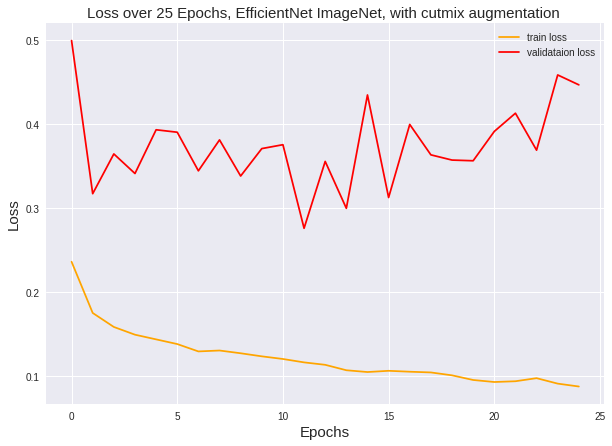

In [ ]:

# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(all_metrics_dicts_nocutmix[3]['training_loss'], color='orange', label='train loss')
plt.plot(all_metrics_dicts_nocutmix[3]['validation_loss'], color='red', label='validataion loss')
plt.xlabel('Epochs',fontsize=15)
plt.title('Loss over 25 Epochs, EfficientNet ImageNet, with cutmix augmentation ',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.legend()
plt.show()

In [ ]:
tumour_acc = [stat.cpu().numpy() for stat in all_metrics_dicts_nocutmix[3]['tumour_acc']]
stroma_acc = [stat.cpu().numpy() for stat in all_metrics_dicts_nocutmix[3]['stroma_acc']]
normal_acc = [stat.cpu().numpy() for stat in all_metrics_dicts_nocutmix[3]['normal_acc']]
total_acc = [stat.cpu().numpy() for stat in all_metrics_dicts_nocutmix[3]['total_acc']]

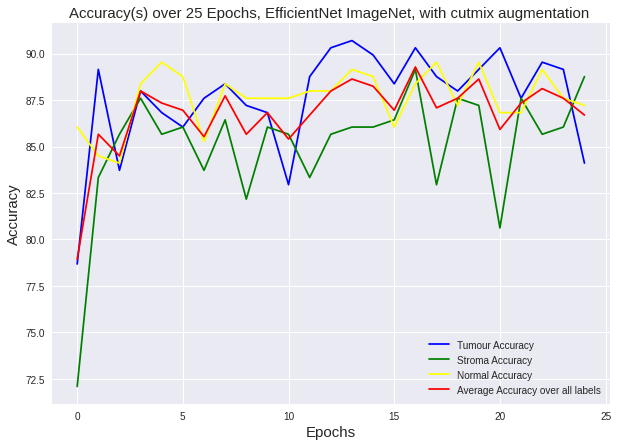

In [ ]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(tumour_acc, color='blue', label='Tumour Accuracy')
plt.plot(stroma_acc, color='green', label='Stroma Accuracy')
plt.plot(normal_acc, color='yellow', label='Normal Accuracy')
plt.plot(total_acc, color='red', label='Average Accuracy over all labels')
plt.xlabel('Epochs',fontsize=15)
plt.title('Accuracy(s) over 25 Epochs, EfficientNet ImageNet, with cutmix augmentation ',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()
plt.show()

In [ ]:
#import cv2
from PIL import Image
from random import randint 

import random

#from torch.utils.data import Dataset, DataLoader

from tiatoolbox.tools import patchextraction
import time
import os
import copy

plt.style.use('seaborn')

print('hello')

def get_rois(list_of_roi_cords, wsi_loc):
    wsi_obj = ops.OpenSlide(wsi_loc)
    rois =  list()
    for cord in list_of_roi_cords:
        img = wsi_reader_v1.read_bounds(cord, resolution=0, units="level")
        rois.append(img)
    return rois


images = get_rois()

plt.imshow(images[0])

### Testing Data

In [ ]:
class WSSS4LUAD_test(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(test_X_data)
    self.labels = np.array(test_y_data)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples

WSSS4LUAD_dataset_test= WSSS4LUAD_test(valid_transforms)
dataloader_WSSS4LUAD_test = DataLoader(dataset = WSSS4LUAD_dataset_test, batch_size = 1, shuffle = False)

In [ ]:
# Function to test the model 
def test(model): 
    # Load the model that we saved at the end of the training loop 
   
    stroma_correct = 0.0
    tumour_correct = 0.0
    normal_correct = 0.0  
    running_accuracy = 0 
    total = 0 
    total_outputs = list()
    with torch.no_grad(): 
        for data in dataloader_WSSS4LUAD_test: 
            inputs, outputs = data['image'].to(device), data['label'].to(device)
            outputs = outputs.to(torch.float32) 
            predicted_outputs =  model(inputs) 
            

            predicted_outputs[predicted_outputs >= 0.5] = 1
            predicted_outputs[predicted_outputs<0.5] = 0
            total_outputs.extend(predicted_outputs)
            tumour_correct += (predicted_outputs[:,0] == outputs[:,0]).sum()
            stroma_correct += (predicted_outputs[:,1] == outputs[:,1]).sum()
            normal_correct += (predicted_outputs[:,2] == outputs[:,2]).sum()    
            total+= 1 
 
   
    
    return (100*tumour_correct/total),(100*stroma_correct/total),(100*normal_correct/total), total_outputs

In [ ]:
#LUAD_classifier.load_state_dict(torch.load('/content/drive/MyDrive/base_with_aug.pth')['model_state_dict'])

In [ ]:
def precision(y_preds,y_true):
  precision_all = precision_score(y_true, y_preds, average=None)
  return precision_all[0], precision_all[1], precision_all[2]

In [ ]:
def recall(y_preds,y_true):
  recall_all = recall_score(y_true, y_preds, average=None)
  return recall_all[0], recall_all[1], recall_all[2]

In [ ]:
def f1(y_preds,y_true):
  f1_score_all = f1_score(y_true, y_preds, average=None)
  return f1_score_all[0], f1_score_all[1], f1_score_all[2]

In [ ]:
def create_confusion_matrix(y_preds,y_true):
  return confusion_matrix(y_true, y_preds, normalize='true',labels = [1,0])

In [ ]:
test_y_data = np.array(test_y_data)

In [ ]:
tests = test(resnet34_LUAD)

In [ ]:
gain_all_preds = [prediction.cpu().numpy() for prediction in tests[3]]

In [ ]:
f1(gain_all_preds,test_y_data)

(0.868421052631579, 0.841688654353562, 0.45378151260504207)

In [ ]:
test()

In [ ]:
def test_all_classifiers(models):
  tumour_accuracys = list()
  stroma_accuracys = list()
  normal_accuracys = list()
  tumour_precision = list()
  stroma_precision = list()
  normal_precision = list()
  tumour_recall = list()
  stroma_recall = list()
  normal_recall = list()
  tumour_f1 = list()
  stroma_f1 = list()
  normal_f1 = list()
  confusion_matrices = list()
  prediction_li = list()

  for i in range(len(models)):
    print(classifier_paths[i])
    #LUAD_classifier = model()

    #model.eval()
    this_test = test(models[i])
    print(this_test[0])

    gain_all_preds = [prediction.cpu().numpy() for prediction in this_test[3]]
    gain_all_preds= np.array(gain_all_preds)
    tumour_accuracys.append(this_test[0].cpu().numpy())
    stroma_accuracys.append(this_test[1].cpu().numpy())
    normal_accuracys.append(this_test[2].cpu().numpy())
    #print(this_test[0])
    precisions = precision(gain_all_preds, test_y_data)

    recalls = recall(gain_all_preds, test_y_data)
    f1s = f1(gain_all_preds, test_y_data)
    tumour_precision.append(precisions[0])
    tumour_recall.append(recalls[0])
    tumour_f1.append(f1s[0])
    stroma_precision.append(precisions[1])
    stroma_recall.append(recalls[1])
    stroma_f1.append(f1s[1])
    normal_precision.append(precisions[2])
    normal_recall.append(recalls[2])
    normal_f1.append(f1s[2])
    #print(type(gain_all_preds[0]))
    confusion_matrices.append([create_confusion_matrix(gain_all_preds[:,0],test_y_data[:,0]), create_confusion_matrix(gain_all_preds[:,1],test_y_data[:,1]), create_confusion_matrix(gain_all_preds[:,2],test_y_data[:,2])])
    #create_confusion_matrix(gain_all_preds,test_y_data)
    prediction_li.append(gain_all_preds)

  
  tumour_dictionary = {
      'Tumour Accuracy' : tumour_accuracys,
      'Tumour Precision': tumour_precision,
      'Tumour Recall' : tumour_recall,
      'Tumour F1' : tumour_f1 
  }
  stroma_dictionary = {
      'Stroma Accuracy' : stroma_accuracys,
      'Stroma Precision': stroma_precision,
      'Stroma Recall' : stroma_recall,
      'Stroma F1' : stroma_f1 
  }
  normal_dictionary = {
      'Normal Accuracy' : normal_accuracys,
      'Normal Precision': normal_precision,
      'Normal Recall' : normal_recall,
      'Normal F1' : normal_f1 
  }
  return tumour_dictionary, stroma_dictionary, normal_dictionary, confusion_matrices, test_y_data, prediction_li







In [ ]:
classifier_paths = ['/content/drive/MyDrive/resnet18_LUAD_nocutmix.pth','/content/drive/MyDrive/resnet34_LUAD_nocutmix.pth','/content/drive/MyDrive/resnet50_LUAD_nocutmix.pth','/content/drive/MyDrive/efficientnet_LUAD_nocutmix.pth', '/content/drive/MyDrive/resnet18_LUAD_withcutmix.pth','/content/drive/MyDrive/resnet34_LUAD_withcutmix.pth', '/content/drive/MyDrive/resnet50_LUAD_withcutmix.pth', '/content/drive/MyDrive/efficientnet_LUAD_withcutmix.pth']

resnet18_LUAD_no_cutmix = model_res(torchvision.models.resnet18(pretrained=True)).to(device)
resnet34_LUAD_no_cutmix = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
resnet50_LUAD_no_cutmix = model_config_50(torchvision.models.resnet50(pretrained=True)).to(device)
efficientnet_LUAD_no_cutmix = model_config(torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)).to(device)

resnet18_LUAD_with_cutmix = model_res(torchvision.models.resnet18(pretrained=True)).to(device)
resnet34_LUAD_with_cutmix = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
resnet50_LUAD_with_cutmix = model_config_50(torchvision.models.resnet50(pretrained=True)).to(device)
efficientnet_LUAD_with_cutmix = model_config(torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)).to(device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
resnet18_LUAD_no_cutmix.load_state_dict(torch.load(classifier_paths[0])['model_state_dict'])
resnet18_LUAD_no_cutmix.eval()

resnet34_LUAD_no_cutmix.load_state_dict(torch.load(classifier_paths[1])['model_state_dict'])
resnet34_LUAD_no_cutmix.eval()

resnet50_LUAD_no_cutmix.load_state_dict(torch.load(classifier_paths[2])['model_state_dict'])
resnet50_LUAD_no_cutmix.eval()


efficientnet_LUAD_no_cutmix.load_state_dict(torch.load(classifier_paths[3])['model_state_dict'])
efficientnet_LUAD_no_cutmix.eval()

resnet18_LUAD_with_cutmix.load_state_dict(torch.load(classifier_paths[4])['model_state_dict'])
resnet18_LUAD_with_cutmix.eval()

resnet34_LUAD_with_cutmix.load_state_dict(torch.load(classifier_paths[5])['model_state_dict'])
resnet34_LUAD_with_cutmix.eval()

resnet50_LUAD_with_cutmix.load_state_dict(torch.load(classifier_paths[6])['model_state_dict'])
resnet50_LUAD_with_cutmix.eval()


efficientnet_LUAD_with_cutmix.load_state_dict(torch.load(classifier_paths[7])['model_state_dict'])
efficientnet_LUAD_with_cutmix.eval()

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [ ]:
classifiers_all = [resnet18_LUAD_no_cutmix, resnet34_LUAD_no_cutmix, resnet50_LUAD_no_cutmix, efficientnet_LUAD_no_cutmix, resnet18_LUAD_with_cutmix, resnet34_LUAD_with_cutmix, resnet50_LUAD_with_cutmix, efficientnet_LUAD_with_cutmix]

In [ ]:
classifier_paths[0]

'/content/drive/MyDrive/resnet18_LUAD_nocutmix.pth'

In [ ]:
tests[0]

tensor(93.3100, device='cuda:0')

In [ ]:
all_classifiers_statistics = test_all_classifiers(classifiers_all)

/content/drive/MyDrive/resnet18_LUAD_nocutmix.pth
tensor(79.6334, device='cuda:0')
/content/drive/MyDrive/resnet34_LUAD_nocutmix.pth
tensor(86.1507, device='cuda:0')
/content/drive/MyDrive/resnet50_LUAD_nocutmix.pth
tensor(87.3727, device='cuda:0')
/content/drive/MyDrive/efficientnet_LUAD_nocutmix.pth
tensor(89.8167, device='cuda:0')
/content/drive/MyDrive/resnet18_LUAD_withcutmix.pth
tensor(75.9674, device='cuda:0')
/content/drive/MyDrive/resnet34_LUAD_withcutmix.pth
tensor(86.1507, device='cuda:0')
/content/drive/MyDrive/resnet50_LUAD_withcutmix.pth
tensor(87.1690, device='cuda:0')
/content/drive/MyDrive/efficientnet_LUAD_withcutmix.pth
tensor(89.4094, device='cuda:0')


In [ ]:
all_classifiers_statistics

({'Tumour Accuracy': [array(79.63341, dtype=float32),
   array(86.15072, dtype=float32),
   array(87.37271, dtype=float32),
   array(89.8167, dtype=float32),
   array(75.967415, dtype=float32),
   array(86.15072, dtype=float32),
   array(87.169044, dtype=float32),
   array(89.40937, dtype=float32)],
  'Tumour Precision': [0.991044776119403,
   0.9787798408488063,
   0.986737400530504,
   0.9846547314578005,
   0.9936507936507937,
   0.9865229110512129,
   0.9867021276595744,
   0.9820971867007673],
  'Tumour Recall': [0.7738927738927739,
   0.8601398601398601,
   0.8671328671328671,
   0.8974358974358975,
   0.7296037296037297,
   0.8531468531468531,
   0.8648018648018648,
   0.8951048951048951],
  'Tumour F1': [0.8691099476439791,
   0.9156327543424317,
   0.923076923076923,
   0.9390243902439025,
   0.8413978494623656,
   0.915,
   0.9217391304347826,
   0.9365853658536586]},
 {'Stroma Accuracy': [array(91.6497, dtype=float32),
   array(82.89206, dtype=float32),
   array(81.26273, dt

In [ ]:
def create_multiclass_labels(ys):
  labels = list()
  for y in ys:
    if list(y) == [0,0,0]:
      labels.append(0)
    elif list(y) == [1,0,0]:
      labels.append(1)
    elif list(y) == [0,1,0]:
      labels.append(2)
    elif list(y) == [0,0,1]:
      labels.append(3)
    elif list(y) == [1,1,0]:
      labels.append(4)
    elif list(y==[1,1,1]):
      labels.append(5)
    else:
      
      labels.append(0)
  return labels


In [ ]:
create_multiclass_labels(all_classifiers_statistics[4])

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 2,


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

mlc = confusion_matrix(create_multiclass_labels(all_classifiers_statistics[4]), create_multiclass_labels(all_classifiers_statistics[5][7].astype(np.int)), normalize="true")

In [ ]:
df_cm = pd.DataFrame(mlc, index=['Other','Tumour','Stroma','Normal','Tumour-Stroma','Tumour-Stroma-Normal'], columns=['Other','Tumour','Stroma','Normal','Tumour-Stroma','Tumour-Stroma-Normal'])

<AxesSubplot:title={'center':'EfficientNet with cutmix'}>

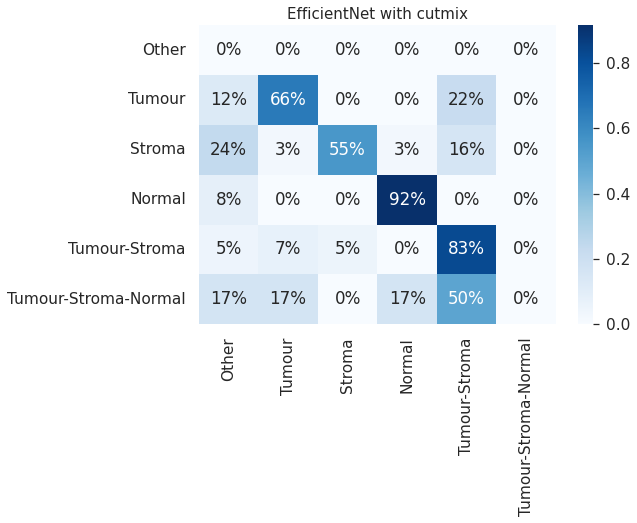

In [ ]:
sns.set(font_scale=1.4)
plt.title('EfficientNet with cutmix',fontsize=15)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt=".0%")


In [ ]:
a = [1,1,0]
b = [1,1,0]

print(a==b)

True


In [ ]:
create_multiclass_labels(create_multiclass_labels(all_classifiers_statistics[5][0].astype(np.int)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

array([], dtype=float64)

In [ ]:
sns.heatmap(mlc, annot=True, fmt='.2f', xticklabels=['tumour','stroma','normal'], yticklabels=['tumour','stroma','normal'])


ValueError: ignored

In [ ]:
df_tumour = pd.DataFrame(all_classifiers_statistics[0],index = ['Resnet18_no_cutmix','Resnet34_no_cutmix', 'Resnet50_no_cutmix', 'Efficient_net_no_cutmix', 'Resnet18_cutmix', 'Resnet34_cutmix', 'Resnet50_cutmix', 'Efficient_net_cutmix'])

In [ ]:
df_tumour.style.highlight_max(color = 'lightgreen', axis = 0)


In [ ]:
df_stroma = pd.DataFrame(all_classifiers_statistics[1],index = ['Resnet18_no_cutmix','Resnet34_no_cutmix', 'Resnet50_no_cutmix', 'Efficient_net_no_cutmix', 'Resnet18_cutmix', 'Resnet34_cutmix', 'Resnet50_cutmix', 'Efficient_net_cutmix'])

In [ ]:
df_stroma.style.highlight_max(color = 'lightgreen', axis = 0)


In [ ]:
df_normal = pd.DataFrame(all_classifiers_statistics[2],index = ['Resnet18_no_cutmix','Resnet34_no_cutmix', 'Resnet50_no_cutmix', 'Efficient_net_no_cutmix', 'Resnet18_cutmix', 'Resnet34_cutmix', 'Resnet50_cutmix', 'Efficient_net_cutmix'])

In [ ]:
df_normal

Normal Accuracy  Normal Precision  Normal Recall  \
Resnet18_no_cutmix             97.14868          1.000000       0.533333   
Resnet34_no_cutmix             98.16701          0.920000       0.766667   
Resnet50_no_cutmix             97.96335          0.794118       0.900000   
Efficient_net_no_cutmix       96.334015          0.642857       0.900000   
Resnet18_cutmix                98.77801          1.000000       0.800000   
Resnet34_cutmix                98.57434          0.960000       0.800000   
Resnet50_cutmix                98.57434          0.960000       0.800000   
Efficient_net_cutmix          98.370674          0.958333       0.766667   

                         Normal F1  
Resnet18_no_cutmix        0.695652  
Resnet34_no_cutmix        0.836364  
Resnet50_no_cutmix        0.843750  
Efficient_net_no_cutmix   0.750000  
Resnet18_cutmix           0.888889  
Resnet34_cutmix           0.872727  
Resnet50_cutmix           0.872727  
Efficient_net_cutmix      0.851852

In [ ]:
df_normal.style.highlight_max(color = 'lightgreen', axis = 0)


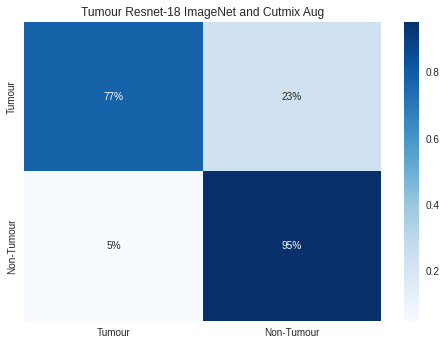

In [ ]:
names = ['Tumour', 'Non-Tumour']
df_cm = pd.DataFrame(all_classifiers_statistics[3][0][0],index = names, columns = names)

sns.heatmap(df_cm, cmap='Blues', annot=True, fmt=".0%")
plt.title('Tumour Resnet-18 ImageNet and Cutmix Aug')
plt.show()

In [ ]:
df_cm

Tumour  Non-Tumour
Tumour      0.773893    0.226107
Non-Tumour  0.048387    0.951613

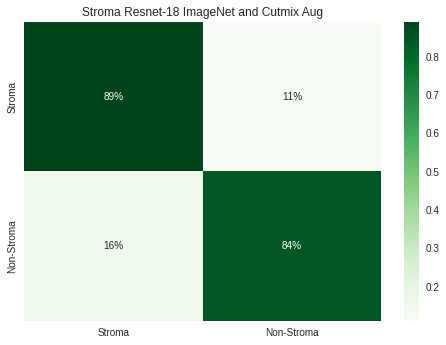

In [ ]:
names = ['Stroma','Non-Stroma' ]
df_cm = pd.DataFrame(all_classifiers_statistics[3][2][1],index = names, columns = names)

sns.heatmap(df_cm, cmap='Greens', annot=True, fmt=".0%")
plt.title('Stroma Resnet-18 ImageNet and Cutmix Aug')
plt.show()

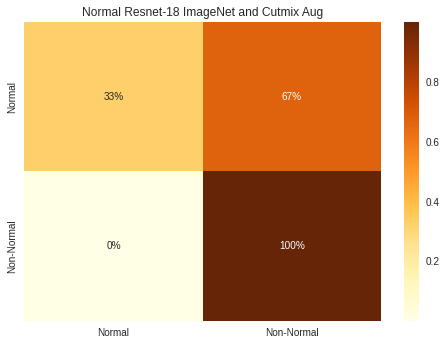

In [ ]:
names = ['Normal','Non-Normal']
df_cm = pd.DataFrame(all_classifiers_statistics[3][0][2],index = names, columns = names)

sns.heatmap(df_cm, cmap='YlOrBr', annot=True, fmt=".0%")
plt.title('Normal Resnet-18 ImageNet and Cutmix Aug')
plt.show()


In [ ]:
all_classifiers_statistics[3][0]

array([[[  66,   58],
        [  50, 1829]],

       [[  94,   32],
        [ 782, 1095]],

       [[1835,   39],
        [ 101,   28]]])